In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import time
import gget
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import scipy
import textwrap

from pydmd import DMD

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import nb_util as nb
import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

2023-11-02 08:34:42.527243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 08:34:42.746448: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 08:34:42.757713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-02 08:34:42.757730: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/../python/hasnain_DMD.py'>

# Load Data

In [2]:
data_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
gene_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"

""" Load the raw expression """
df = pd.read_csv(data_path, index_col=0)

# remove MT and ribosomal genes
all_genes = df.index.to_list()
mt_genes = [x for x in all_genes if x.startswith('MT-')]
rp_genes = [x for x in all_genes if x.startswith('RP')]

print(f"{df.shape=}")
df = df.drop(mt_genes) # drop MT genes
df = df.drop(rp_genes) # drop ribosomal genes
print(f"{df.shape=}")

# rewrite the list without MT genes
gene_names = df.index.to_list()

print(f"{len(all_genes)=} {len(mt_genes)=} {len(gene_names)=}")

""" Load gene lengths """
gf = nb.getGeneLengths(gene_path, gene_names)
print(f"{gf.shape=}")


df.head()

df.shape=(19393, 18)
df.shape=(19235, 18)
len(all_genes)=19393 len(mt_genes)=13 len(gene_names)=19235


/tmp/ipykernel_2938524/4036917658.py:23: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  gf = nb.getGeneLengths(gene_path, gene_names)


gf.shape=(19235, 2)


S1a  S1b  S2a  S2b  S3a  S3b  S4a  S4b  S5a  S5b  S6a  S6b  S7a  \
geneName                                                                    
A1BG       12    5    5    9    2    6    7    3    6    5    5    5    4   
A1CF        0    0    0    0    0    0    0    0    0    0    0    1    2   
A2M         0    0    0    2    0    0    0    0    0    0    1    0    1   
A2ML1       0    0    0    0    0    0    0    1    0    0    0    0    0   
A3GALT2     0    0    0    0    0    0    0    0    0    0    0    0    0   

          S7b  S8a  S8b  S9a  S9b  
geneName                           
A1BG        3    4    5    5    3  
A1CF        0    2    0    0    0  
A2M         0    0    0    0    2  
A2ML1       1    0    0    0    0  
A3GALT2     0    0    0    0    0

# Choose Rank = 7; TPM > 0.5

In [3]:
target = 1e6
threshold = 0.5
rank = 7
tpm = nb.TPM(df, gf, target=target)

# get highly expressed genes
tpm_dist = tpm.mean(axis=1)
mask = (tpm_dist > threshold)
high_exp_genes = tpm_dist[mask].index.to_list()    

# filter and convert to fold changes
d = tpm[tpm.index.isin(high_exp_genes)]
dmd_data = nb.data2DMD(d) 
print(f"{dmd_data.shape=}")

dmd_res = hasnain_DMD.dmd(dmd_data, rank=rank)

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")

print('done')

dmd_data.shape=(8112, 8, 2)
dmd_res['A'].shape=(8112, 8112)
dmd_res['Atilde'].shape=(7, 7)
dmd_res['u_r'].shape=(8112, 7)
dmd_res['L'].shape=(7,)
dmd_res['W'].shape=(7, 7)
dmd_res['Phi'].shape=(8112, 7)
dmd_res['amplitudes'][0].shape=(7, 8)
done


np.real(L).max()=0.9983654588887008
pdf.shape=(7, 2)


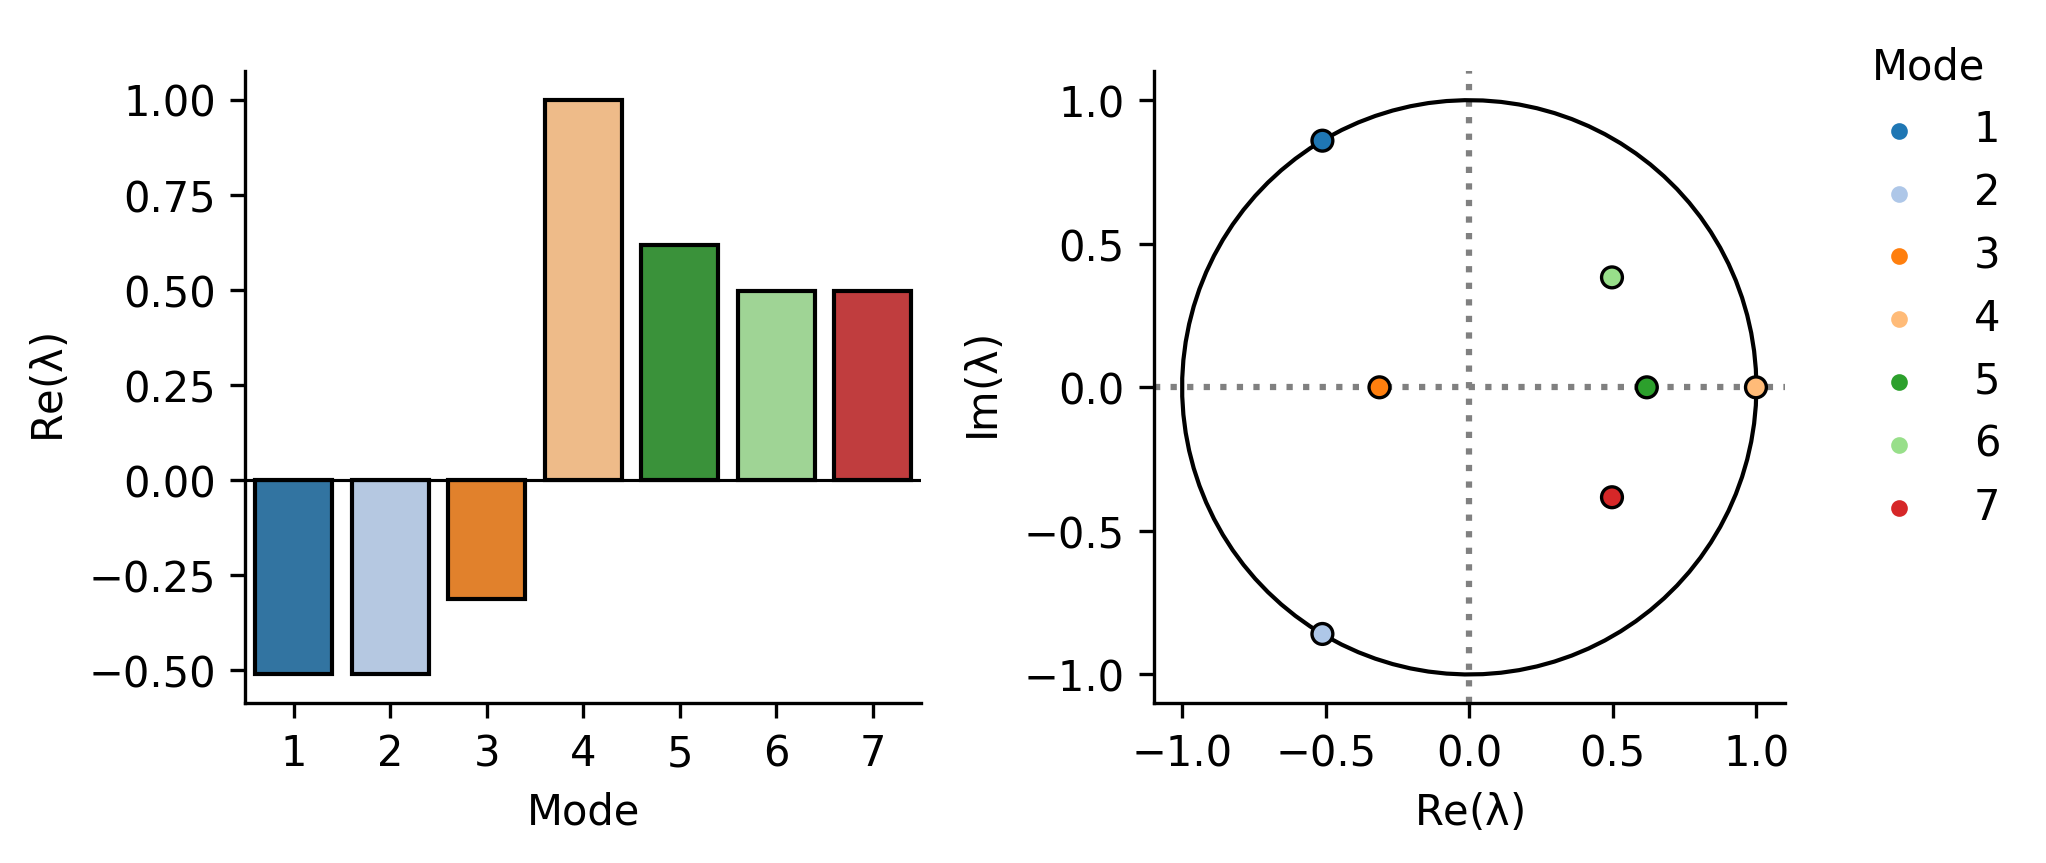

In [4]:
""" Plot DMD eigenvalues  """
t = np.linspace(0, np.pi*2, 100)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 3

fig, axs = plt.subplots(1, 2)

L = dmd_res['L']
print(f"{np.real(L).max()=}")
pdf = pd.DataFrame({'real' : np.real(L),
                    'imaginary' : np.imag(L)})

print(f"{pdf.shape=}")
pdf['mode'] = list(range(1, len(pdf)+1))

# plot real parts
sns.barplot(data=pdf, 
            x='mode',
            y='real',
            hue='mode',
            ax=axs[0],
            dodge=False,
            ec='k',
            palette='tab20',)

axs[0].legend().remove()

axs[0].axhline(y=0, zorder=1, lw=0.75, c='k')
axs[0].set_xlabel("Mode")
axs[0].set_ylabel(r'$\mathregular{Re(\lambda)}$')


# plot the eigenvalues
# make the unit circle
axs[1].plot(np.cos(t), 
         np.sin(t), 
         linewidth=1, 
         c='k',
         zorder=1)

sns.scatterplot(data=pdf,
                x='real', 
                y='imaginary',
                s=100,
                marker=".",
                # legend=False,
                hue='mode',
                ax=axs[1],
                ec='k',
                palette='tab20',
                zorder=3)

# add the axis
axs[1].axvline(x=0, ls=":", c='grey', zorder=0)
axs[1].axhline(y=0, ls=":", c='grey', zorder=0)

axs[1].set_aspect('equal')
axs[1].set_xlabel(r'$\mathregular{Re(\lambda)}$')
axs[1].set_ylabel(r'$\mathregular{Im(\lambda)}$')

sns.move_legend(axs[1], 
                title='Mode',
                frameon=False, 
                loc='upper right',
                markerscale=0.5,
                bbox_to_anchor=(1.4, 1.1))


sns.despine()
plt.tight_layout()

# Visualize predictions

X_pred.shape=(8112, 8, 2) cd=0.9988895320775797


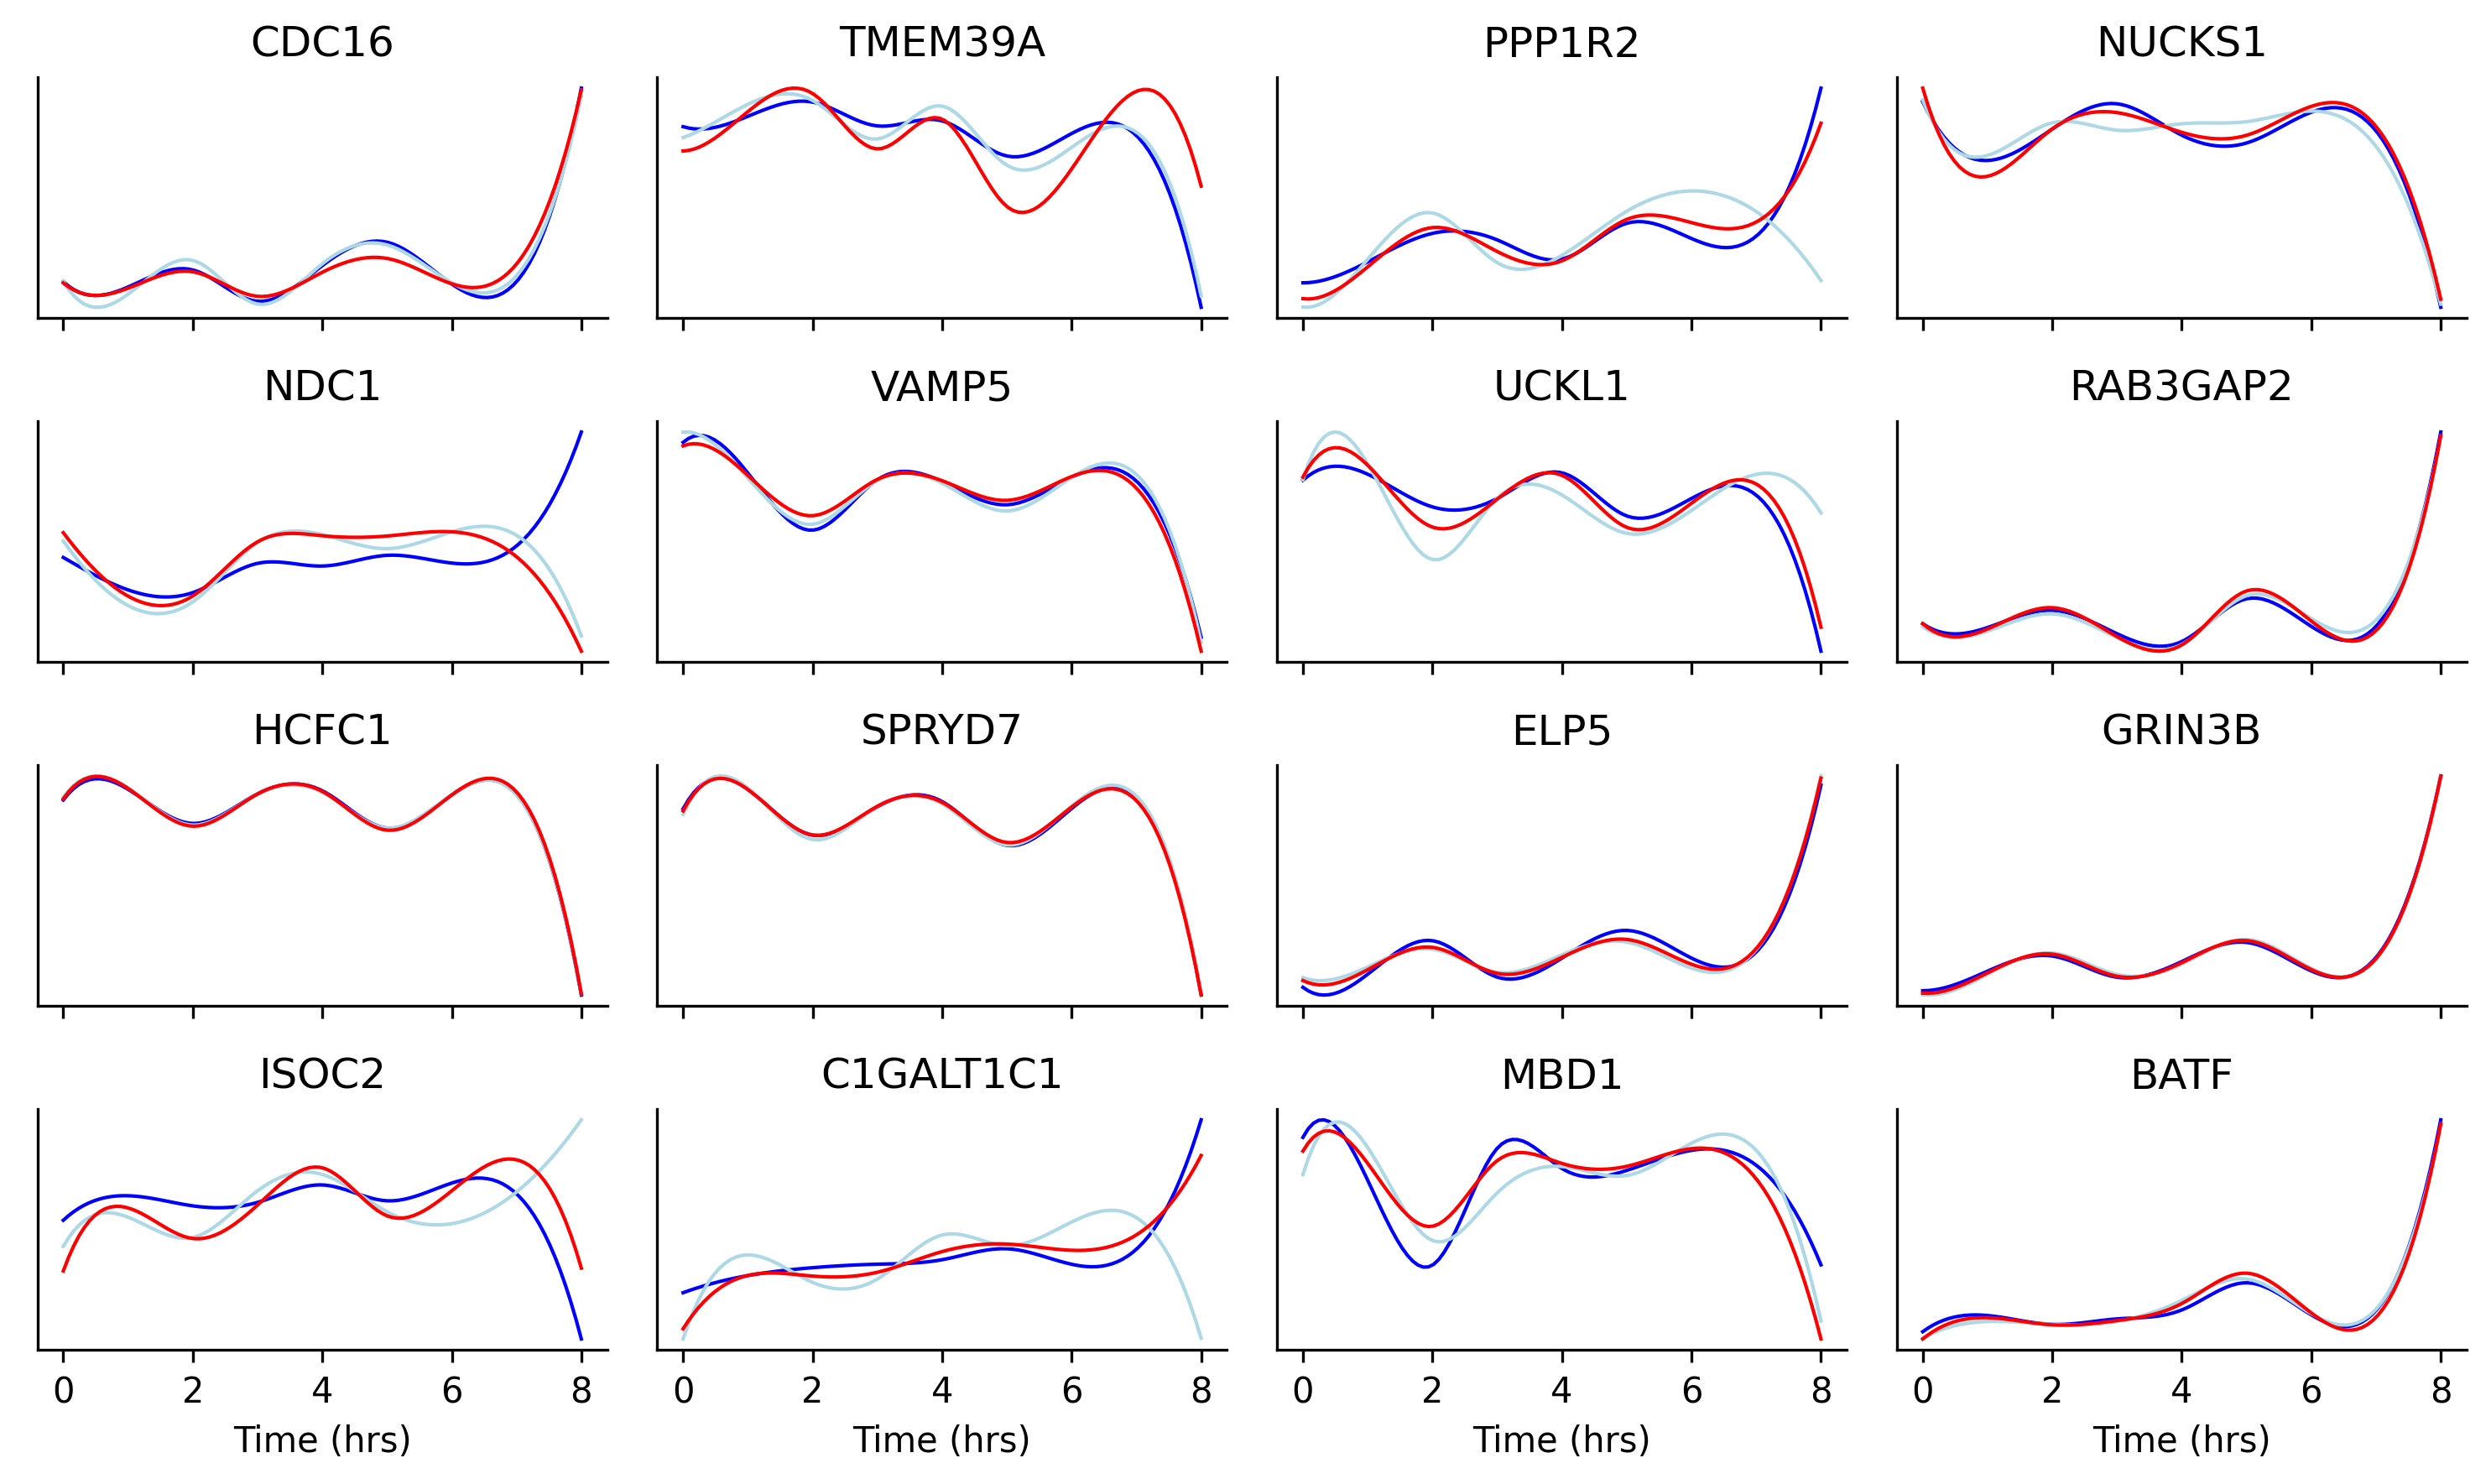

In [5]:
sample_size = 16

gene_labels = pd.DataFrame(high_exp_genes, columns=['gene_name'])
X_pred, cd = hasnain_DMD.get_predictions(dmd_res)

print(f"{X_pred.shape=} {cd=}")

genes = np.random.choice(high_exp_genes, sample_size, replace=False)
gene_ind = [high_exp_genes.index(x) for x in high_exp_genes if x in genes]

def smooth_columns(df, columns, xmin, xmax, n_points=100, power=3, standardize=True):
    """A function to smooth a column"""

    S = np.zeros((n_points, len(columns)))

    for i, column in enumerate(columns):
        y = df[column].to_numpy()
        x = list(range(len(y)))
        x_hat = np.linspace(0, len(y), n_points) 

        spl = make_interp_spline(x, y, k=power)  
        y_hat = spl(x_hat)
        if standardize:
            y_hat =  (y_hat - y_hat.mean())/(y_hat.std())

        S[:, i] = y_hat

    S = pd.DataFrame(S, index=x_hat, columns=columns)
    return S

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 6

fig, axs =  plt.subplots(4, 4, sharex=True)
axs = axs.ravel()

for i, ind in enumerate(gene_ind):
    gene_name = genes[i]

    pdf = pd.DataFrame(dmd_data[ind, :, :], columns=['r1', 'r2'])
    pdf['pred'] = X_pred[ind, :, :].mean(axis=1)
    
    pdf = pdf.reset_index(drop=False)
    pdf['hours'] = pdf['index'] * 8
    pdf = pdf.drop(columns='index')

    pdf = smooth_columns(pdf, ['r1', 'r2', 'pred'], xmin=0, xmax=56)
    pdf = pdf.reset_index(drop=False)
    pdf = pd.melt(pdf, id_vars=['index'])
    
    sns.lineplot(pdf,
                 x='index',
                 y='value',
                 hue='variable',
                 lw=1,
                 legend=False,
                 palette=['blue', 'lightblue','r'],
                 ax=axs[i])

    axs[i].set_ylabel("")
    axs[i].set_yticks([])
    axs[i].set_xlabel("Time (hrs)")
    axs[i].set_title(gene_name)


plt.tight_layout()
sns.despine()

# Get the "signature" of each mode

phi.shape=(8112, 7)


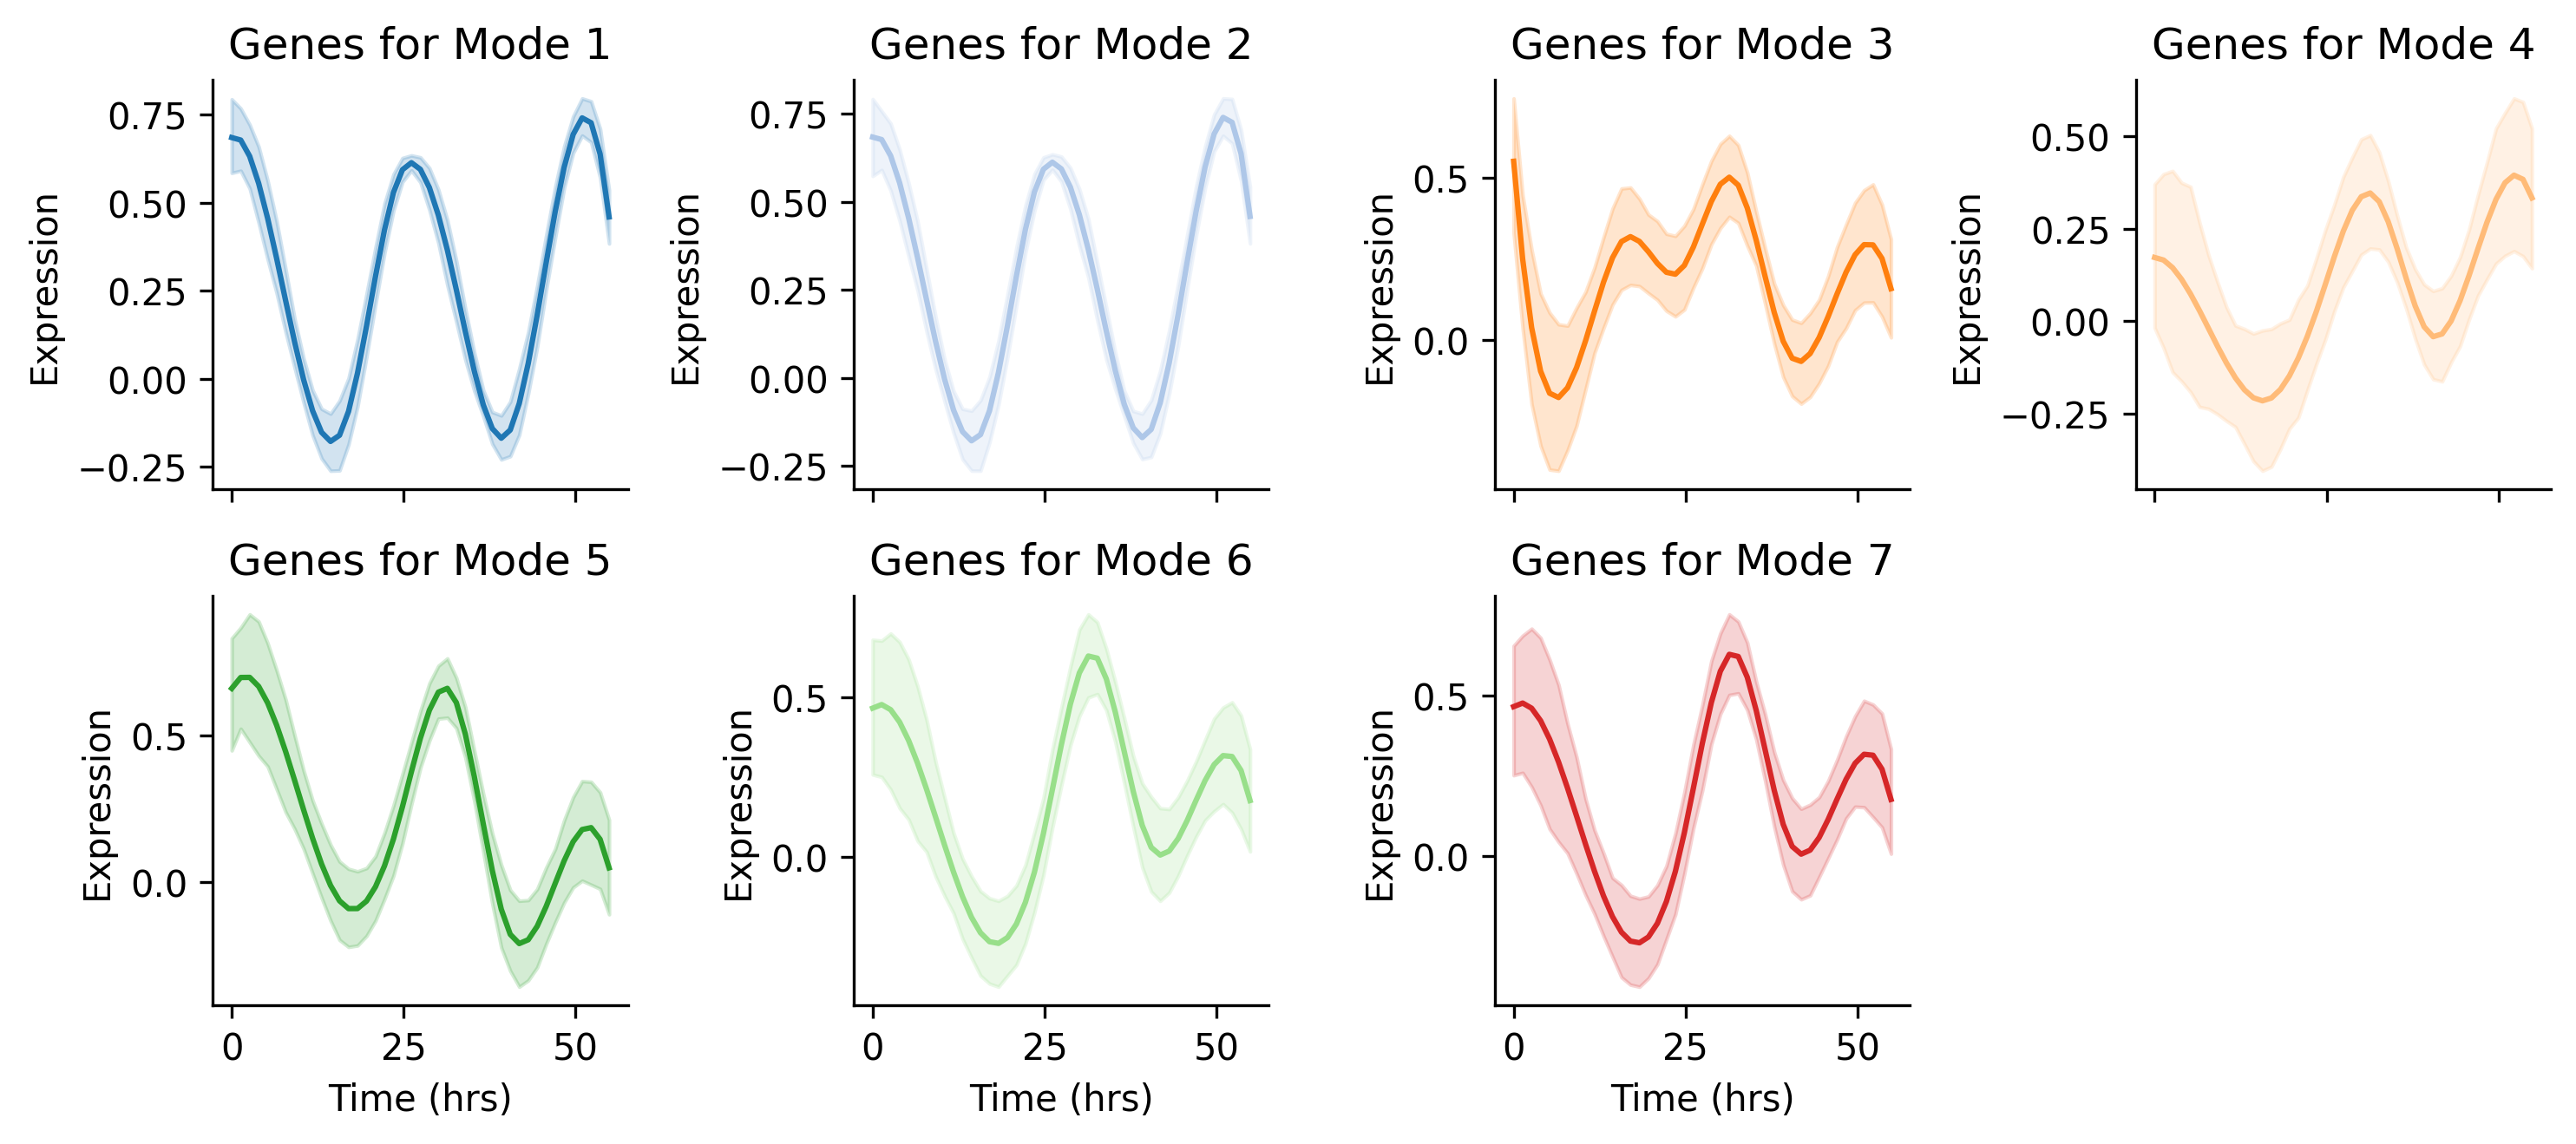

In [6]:
top_n = 50

# get the normalized expression data
pdf = d.copy()
pdf = pdf.reset_index(drop=False)
pdf = nb.meltDf(pdf)
pdf = pdf[pdf['control'] != 'control']

# get the top genes for each mode
phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=high_exp_genes)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)

def smooth_rows(df, n_points=100, power=3, standardize=True):
    """A function to smooth the rows of a dataframe

    args:
        : df (dataframe): m observations by n timepoints
        : n_points (int): number of points to interpolate over
        : power (int): power of the spline
    """

    S = np.zeros((df.shape[0], n_points))

    for i, (idx, row) in enumerate(df.iterrows()):
        
        y = row.values  
        x = list(range(len(y)))
        x_hat = np.linspace(0, len(y), n_points) 

        spl = make_interp_spline(x, y, k=power)  
        smooth_row = spl(x_hat)
        if standardize:
            smooth_row =  (smooth_row - smooth_row.mean())/(smooth_row.std())
        S[i, :] = smooth_row
    
    S = pd.DataFrame(S, index=df.index, columns=x_hat)
    return S

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 4.5

fig, axs = plt.subplots(2, 4, sharex=True)
axs = axs.ravel()

cmap = matplotlib.cm.get_cmap('tab20', 20)
colors = cmap.colors

for i, _mode in enumerate(phi.columns):

    # get top genes for each mode
    top_genes = phi[phi[_mode] <= top_n][_mode].index.to_list()

    # get the normalized expression of those genes
    tmp = pdf[pdf['geneName'].isin(top_genes)]
    tmp = pd.pivot_table(tmp, 
                     index='geneName', 
                     columns='hours',
                     values='value',
                     aggfunc='mean')

    smooth = smooth_rows(tmp, n_points=50, power=3)
    smooth = pd.melt(smooth)
    smooth['hours'] = smooth['variable'] * 8
    smooth = smooth[smooth['hours'] < 56]

    sns.lineplot(data=smooth,
                 x='hours',
                 y='value',
                 ax=axs[i],
                 color=colors[i])

    axs[i].set_title(f"Genes for Mode {_mode+1}")
    axs[i].set_ylabel('Expression')
    axs[i].set_xlabel('Time (hrs)')

    
fig.delaxes(axs[7])
plt.tight_layout()
sns.despine()

# Explore the top genes for each mode

In [7]:
top_n = 200
alpha = 0.05

phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=high_exp_genes)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)


# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

edf = []


for c in phi.columns:
    genes = phi[phi[c] <= top_n][c].index.to_list()
    
    enrich = gget.enrichr(genes, database=db)
    enrich = enrich[['path_name', 'adj_p_val', 'overlapping_genes']]
    enrich = enrich[enrich['adj_p_val'] <= alpha]
    enrich['mode'] = c + 1

    print(f"======== Mode {c+1} ========")
    print(enrich[['path_name']].head(10))

    edf.append(enrich)
    print()
    time.sleep(1)

    
    # break

edf = pd.concat(edf)
print('done')

Thu Nov  2 08:35:39 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


phi.shape=(8112, 7)
======== Mode 1 ========
                                           path_name
0          protein-DNA complex assembly (GO:0065004)
1                 DNA metabolic process (GO:0006259)
2               nucleosome organization (GO:0034728)
3  mitotic sister chromatid segregation (GO:0000070)
4                    chromatin assembly (GO:0031497)
5               chromosome condensation (GO:0030261)
6         DNA-dependent DNA replication (GO:0006261)
7  regulation of mitotic cell cycle phase transit...
8          sister chromatid segregation (GO:0000819)
9  mitochondrial translational elongation (GO:007...



Thu Nov  2 08:35:41 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 2 ========
                                           path_name
0          protein-DNA complex assembly (GO:0065004)
1                 DNA metabolic process (GO:0006259)
2               nucleosome organization (GO:0034728)
3  mitotic sister chromatid segregation (GO:0000070)
4                    chromatin assembly (GO:0031497)
5               chromosome condensation (GO:0030261)
6         DNA-dependent DNA replication (GO:0006261)
7  regulation of mitotic cell cycle phase transit...
8          sister chromatid segregation (GO:0000819)
9  mitochondrial translational elongation (GO:007...



Thu Nov  2 08:35:42 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 3 ========
                                           path_name
0              translational elongation (GO:0006414)
1  mitochondrial translational elongation (GO:007...
2             mitochondrial translation (GO:0032543)
3  mitochondrial translational termination (GO:00...
4             translational termination (GO:0006415)
5  RNA splicing, via transesterification reaction...
6                       mRNA processing (GO:0006397)
7        mRNA splicing, via spliceosome (GO:0000398)
8  regulation of release of cytochrome c from mit...
9  cellular macromolecule biosynthetic process (G...



Thu Nov  2 08:35:44 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 4 ========
                                           path_name
0   cytokine-mediated signaling pathway (GO:0019221)
1          regulation of mRNA stability (GO:0043488)
2        mRNA splicing, via spliceosome (GO:0000398)
3  interferon-gamma-mediated signaling pathway (G...
4  RNA splicing, via transesterification reaction...
5  cellular response to interferon-gamma (GO:0071...
6  regulation of mRNA catabolic process (GO:0061013)
7                       mRNA processing (GO:0006397)
8  antigen processing and presentation of endogen...
9  antigen processing and presentation of exogeno...



Thu Nov  2 08:35:45 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 5 ========
                                           path_name
0  mitochondrial translational elongation (GO:007...
1              translational elongation (GO:0006414)
2             mitochondrial translation (GO:0032543)
3  mitochondrial translational termination (GO:00...
4             translational termination (GO:0006415)
5          response to unfolded protein (GO:0006986)
6       regulation of apoptotic process (GO:0042981)
7                 protein stabilization (GO:0050821)
8  negative regulation of programmed cell death (...
9          protein-DNA complex assembly (GO:0065004)



Thu Nov  2 08:35:47 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 6 ========
                                           path_name
0              translational elongation (GO:0006414)
1   cytokine-mediated signaling pathway (GO:0019221)
2  mitochondrial translational elongation (GO:007...
3  negative regulation of programmed cell death (...
4             mitochondrial translation (GO:0032543)
5       regulation of apoptotic process (GO:0042981)
6          protein-DNA complex assembly (GO:0065004)
7      pre-replicative complex assembly (GO:0036388)
8  mitochondrial translational termination (GO:00...
9  negative regulation of apoptotic process (GO:0...



Thu Nov  2 08:35:49 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 7 ========
                                           path_name
0              translational elongation (GO:0006414)
1   cytokine-mediated signaling pathway (GO:0019221)
2  mitochondrial translational elongation (GO:007...
3  negative regulation of programmed cell death (...
4             mitochondrial translation (GO:0032543)
5       regulation of apoptotic process (GO:0042981)
6          protein-DNA complex assembly (GO:0065004)
7      pre-replicative complex assembly (GO:0036388)
8  mitochondrial translational termination (GO:00...
9  negative regulation of apoptotic process (GO:0...

done


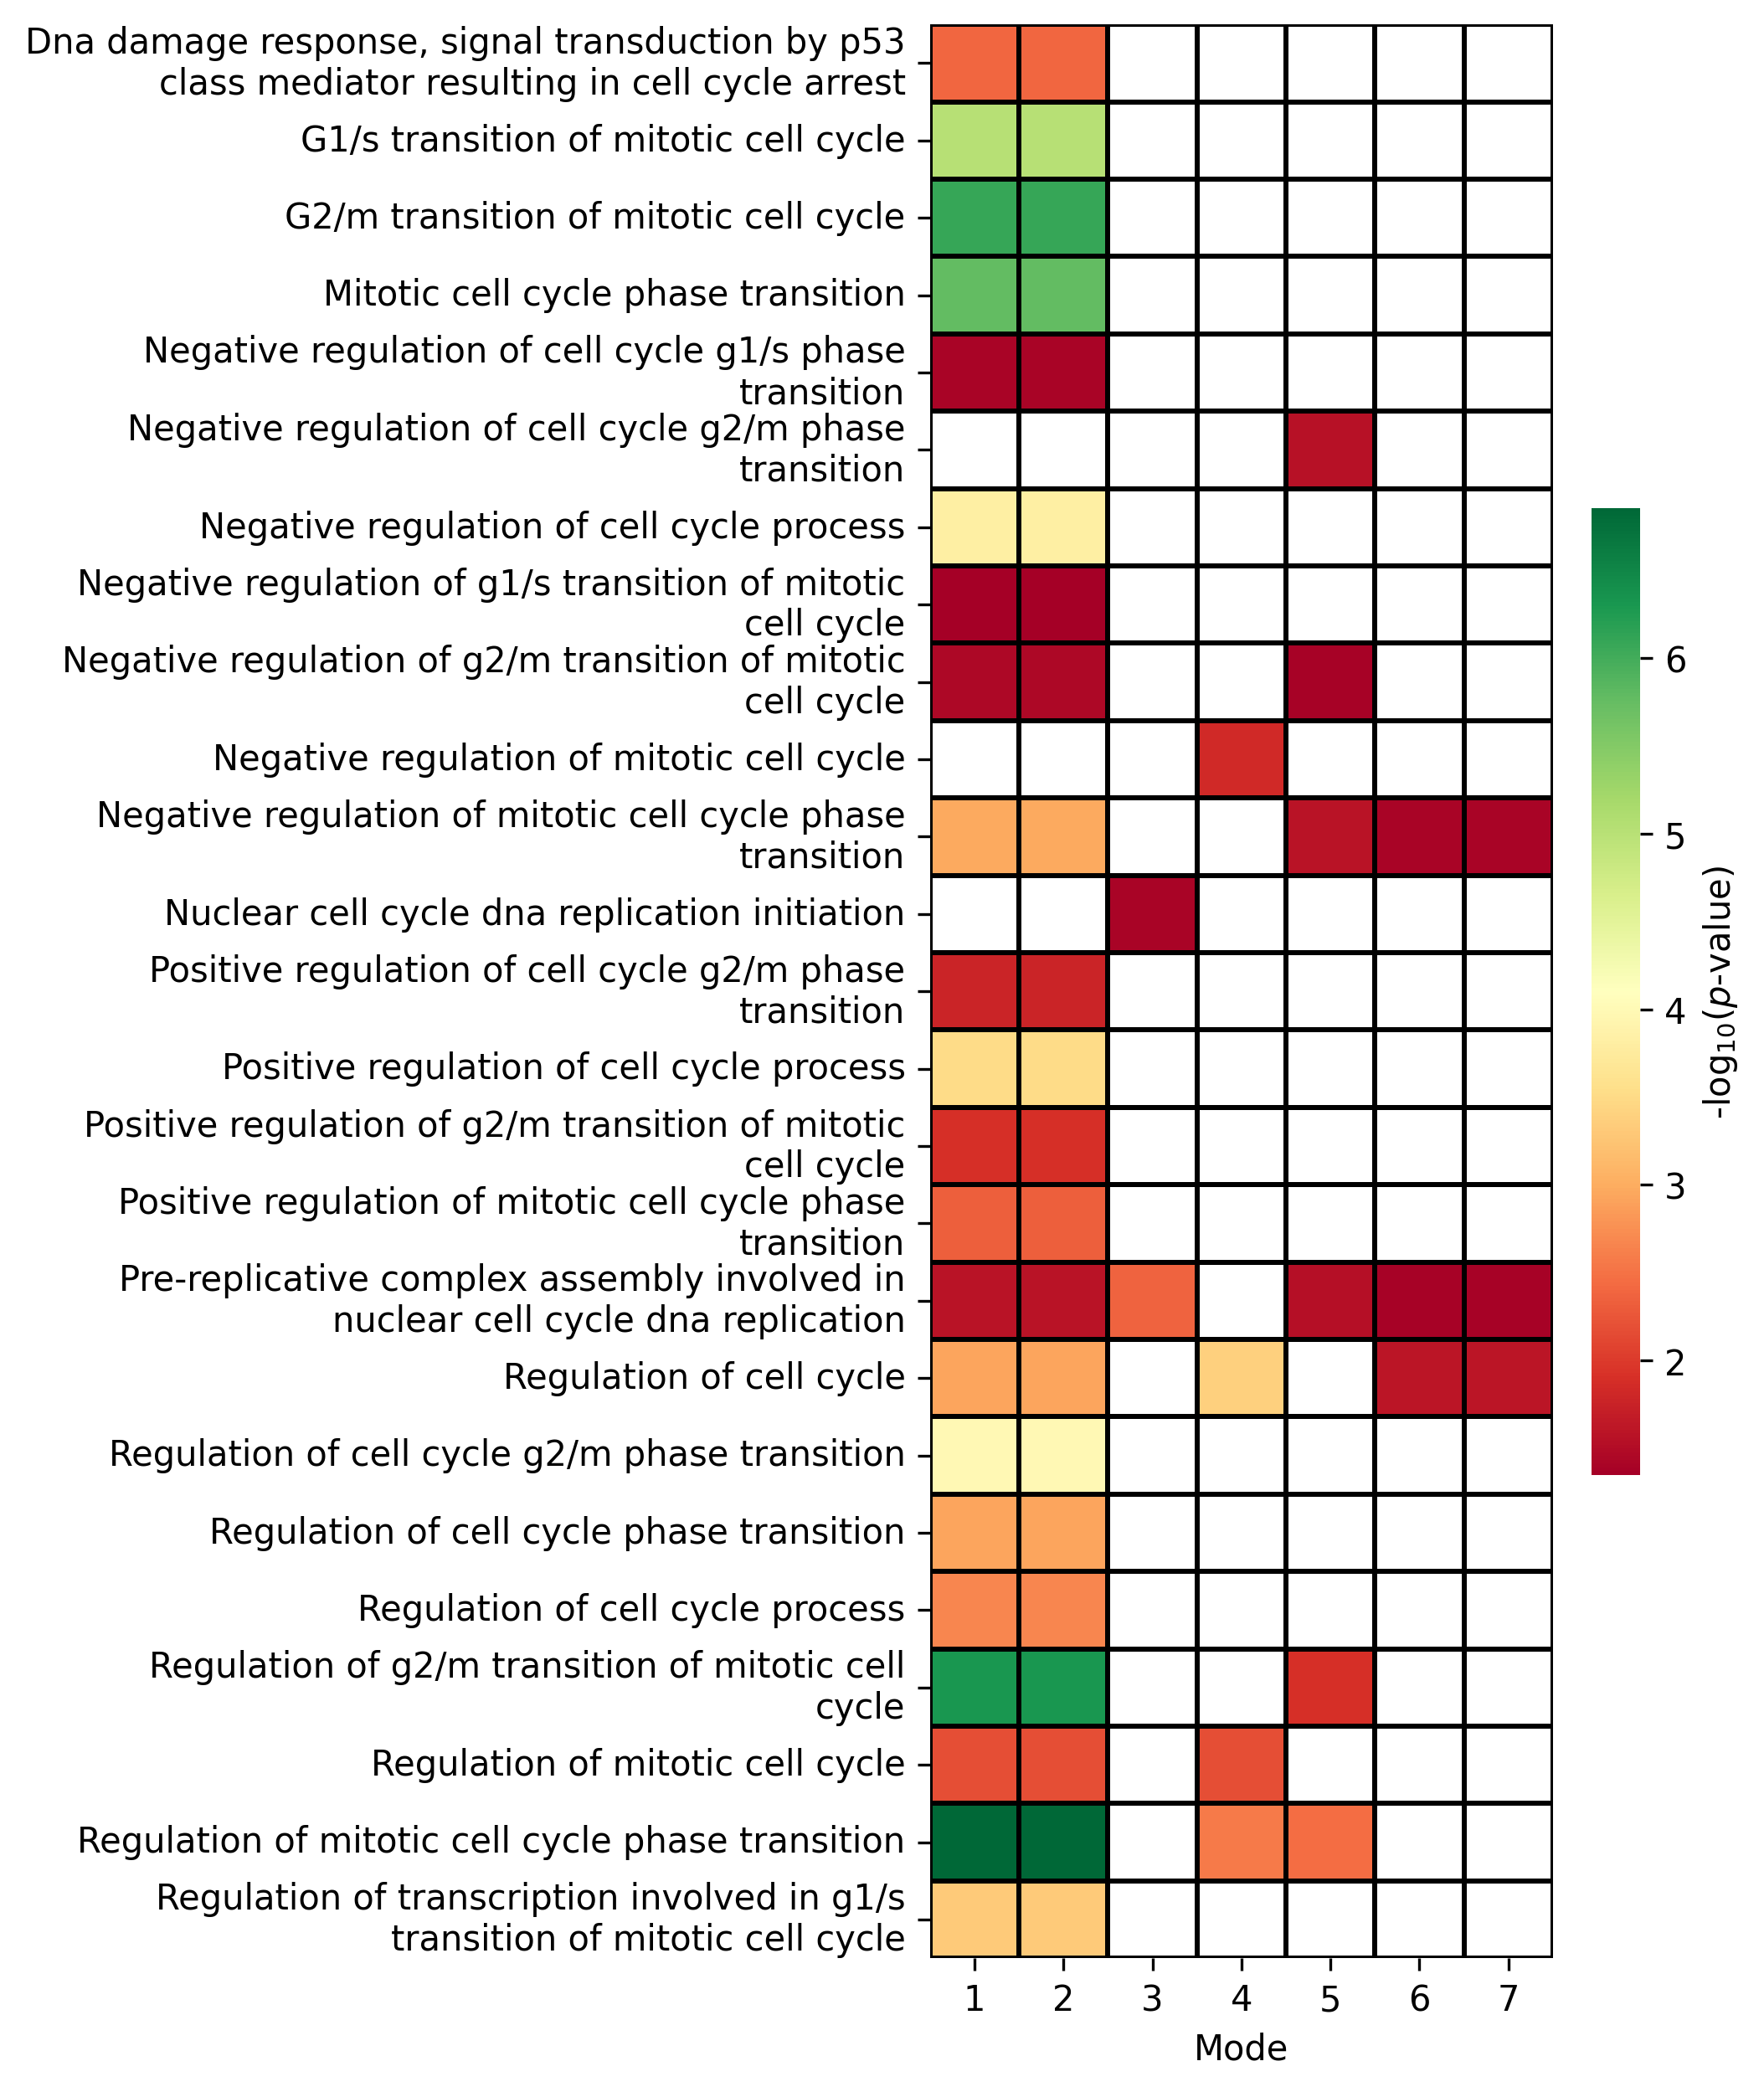

In [8]:
alpha = 0.05

def wrap_ylabels(ax, width):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=False))
    ax.set_yticklabels(labels, rotation=0)

pdf = edf.copy()
pdf = pdf[pdf['adj_p_val'] <= alpha]

pdf['n_gene'] = pdf['overlapping_genes'].apply(lambda x: len(x))
pdf['logp'] = -1 * np.log10(pdf['adj_p_val'])
pdf['name'] = pdf['path_name'].apply(lambda x: x.split("(")[0].capitalize())

# get the cell cycle processes
pdf['cell_cycle'] = pdf['name'].apply(lambda x: 1 if 'cell cycle' in x else 0)
pdf = pdf[pdf['cell_cycle'] == 1]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 10

pdf = pd.pivot_table(pdf, 
                     index='name',
                     columns='mode',
                     values='logp')

sns.heatmap(pdf,
            cmap='RdYlGn',
            lw=1,
            linecolor='k',
            cbar_kws={'label' : r"-log$_{10}$($p$-value)",
                      'shrink' : 0.5})

plt.ylabel("")
plt.xlabel("Mode")
wrap_ylabels(plt.gca(), width=50)


# sns.heatmap(pdf[mode_columns].head(n_plot),
#             lw=1,
#             linecolor='k',
#             annot=True,
#             cbar=False,
#             cmap='viridis')

# plt.ylabel("")
# plt.xlabel("Mode")

In [9]:
# break

# Obersevability Based on Hasnain Method

A.shape=(7, 7) x0_embedded.shape=(7, 2) u.shape=(8112, 7)


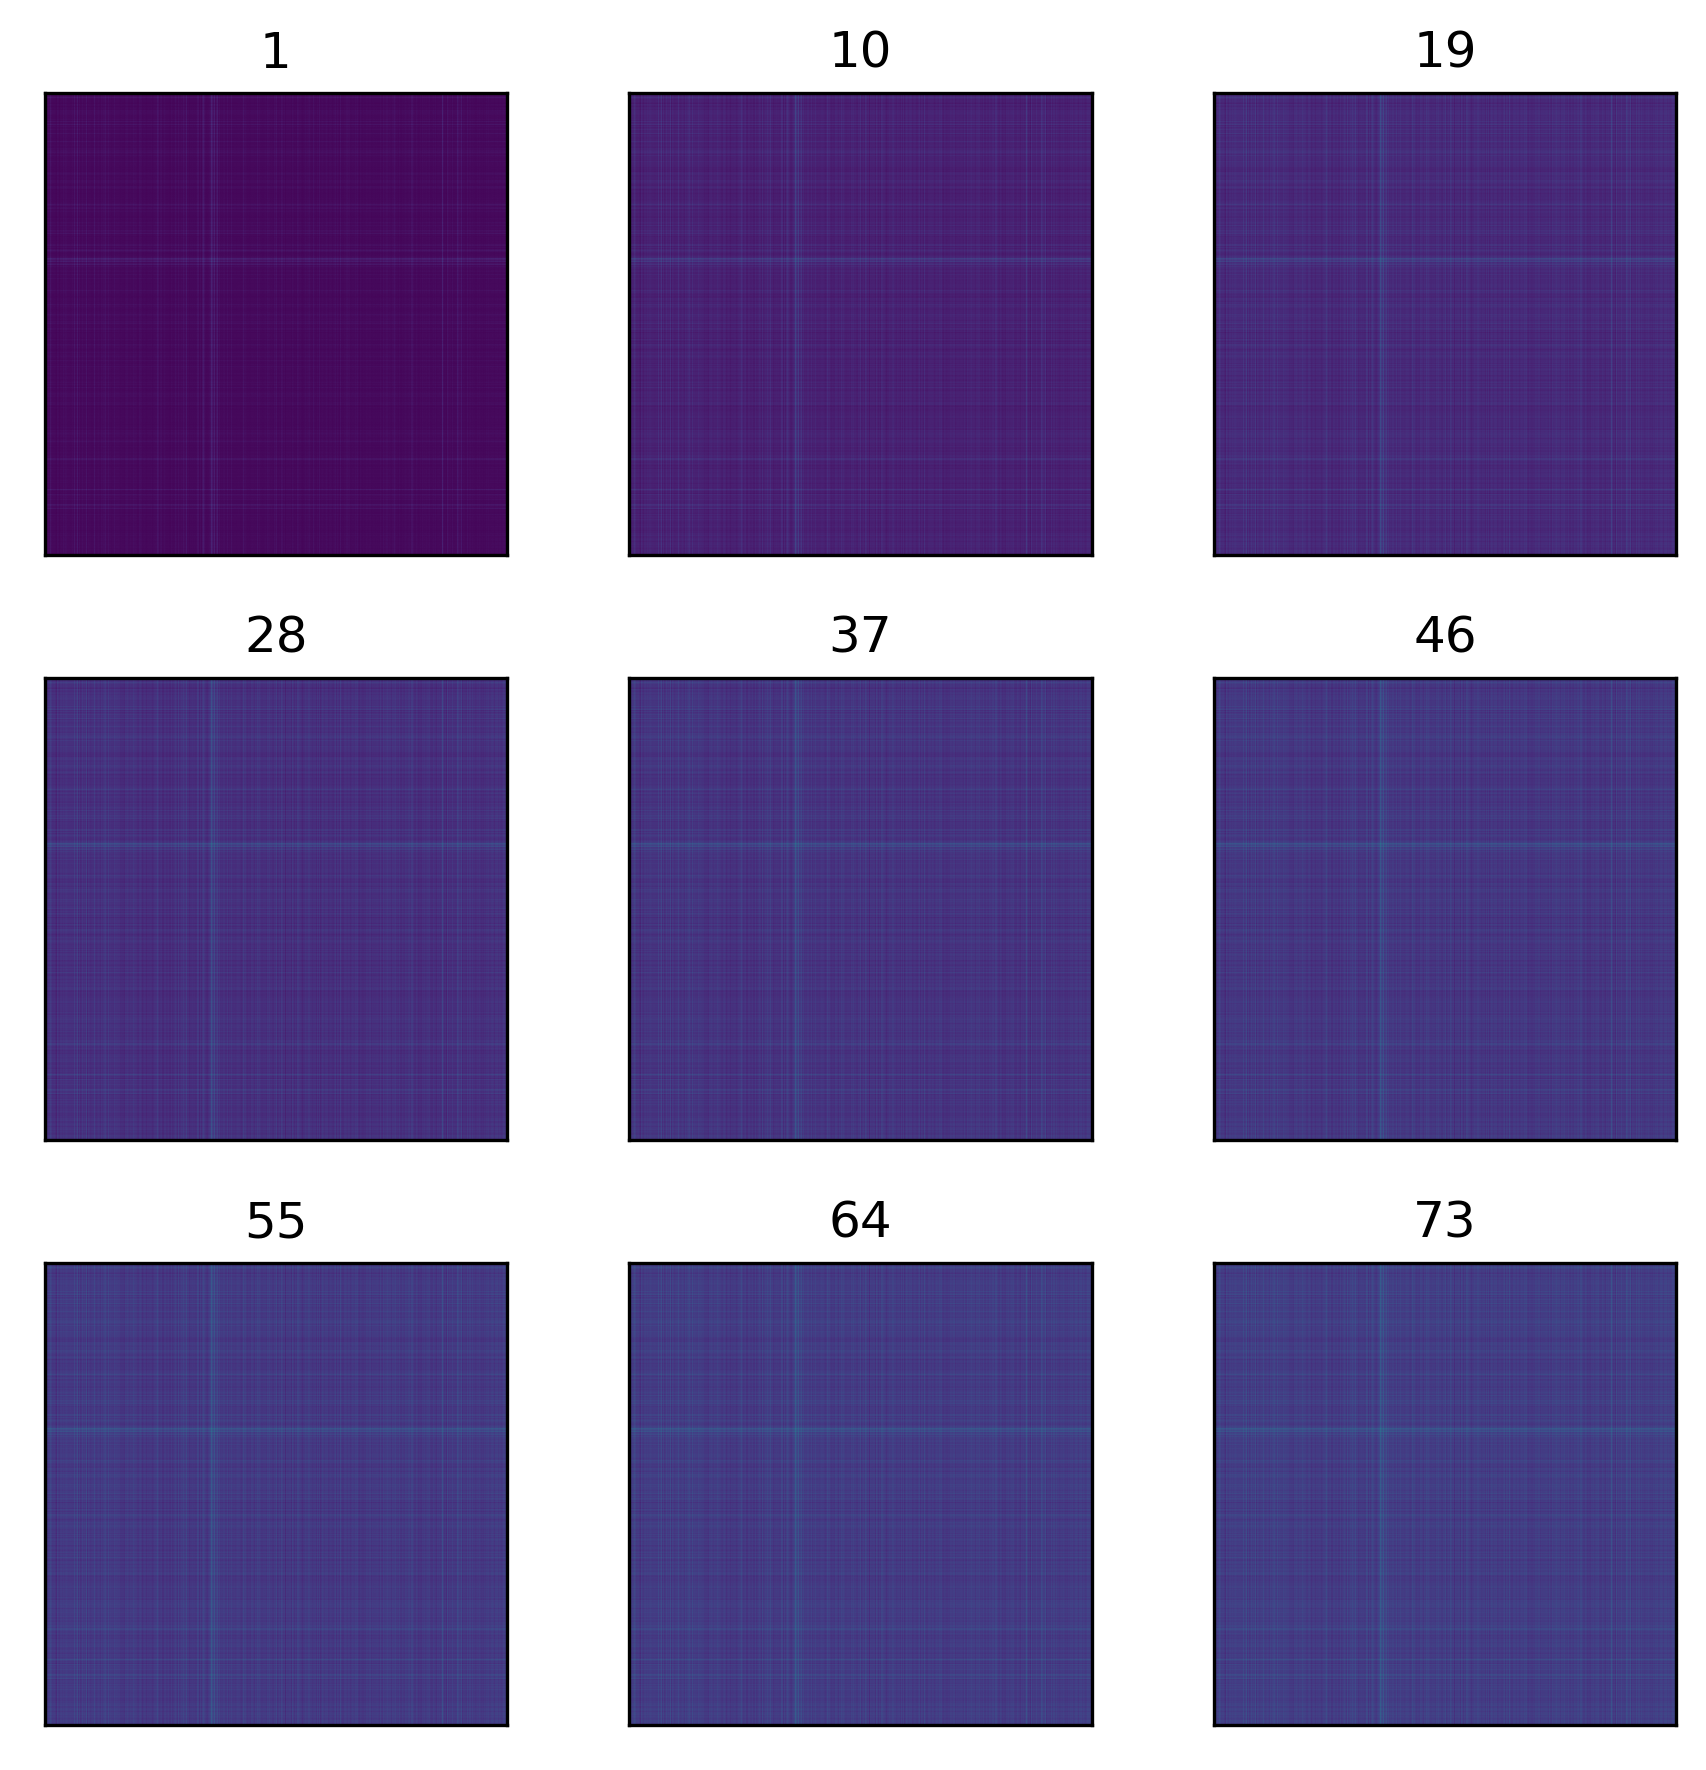

In [10]:
A = dmd_res['Atilde']
u = dmd_res['u_r']
x0_embedded = dmd_res['data_embedded'][:,0,:]

print(f"{A.shape=} {x0_embedded.shape=} {u.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6

fig, axs = plt.subplots(3, 3)
axs = axs.ravel()

for i, nT in enumerate(np.arange(1, 82, 9)):
    
    
    _, Gtemp = hasnain_DMD.gram_matrix(A, 
                                       x0_embedded, 
                                       nT=nT, 
                                       reduced=True, 
                                       projection_matrix=u)

    axs[i].imshow(np.log1p(np.abs(Gtemp)))
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(nT)

plt.tight_layout()

In [11]:
A = dmd_res['Atilde']
u = dmd_res['u_r']
x0_embedded = dmd_res['data_embedded'][:,0,:]

print(f"{A.shape=} {x0_embedded.shape=}  {u.shape=}")
nT = 10
_, G = hasnain_DMD.gram_matrix(A, 
                            x0_embedded, 
                            nT=nT, 
                            reduced=True, 
                            projection_matrix=u)
print(f"{G.shape=}")

A.shape=(7, 7) x0_embedded.shape=(7, 2)  u.shape=(8112, 7)
G.shape=(8112, 8112)


D.shape=(8112,) V.shape=(8112, 8112)
evals.max()=554957.9969 evals.min()=-0.0000


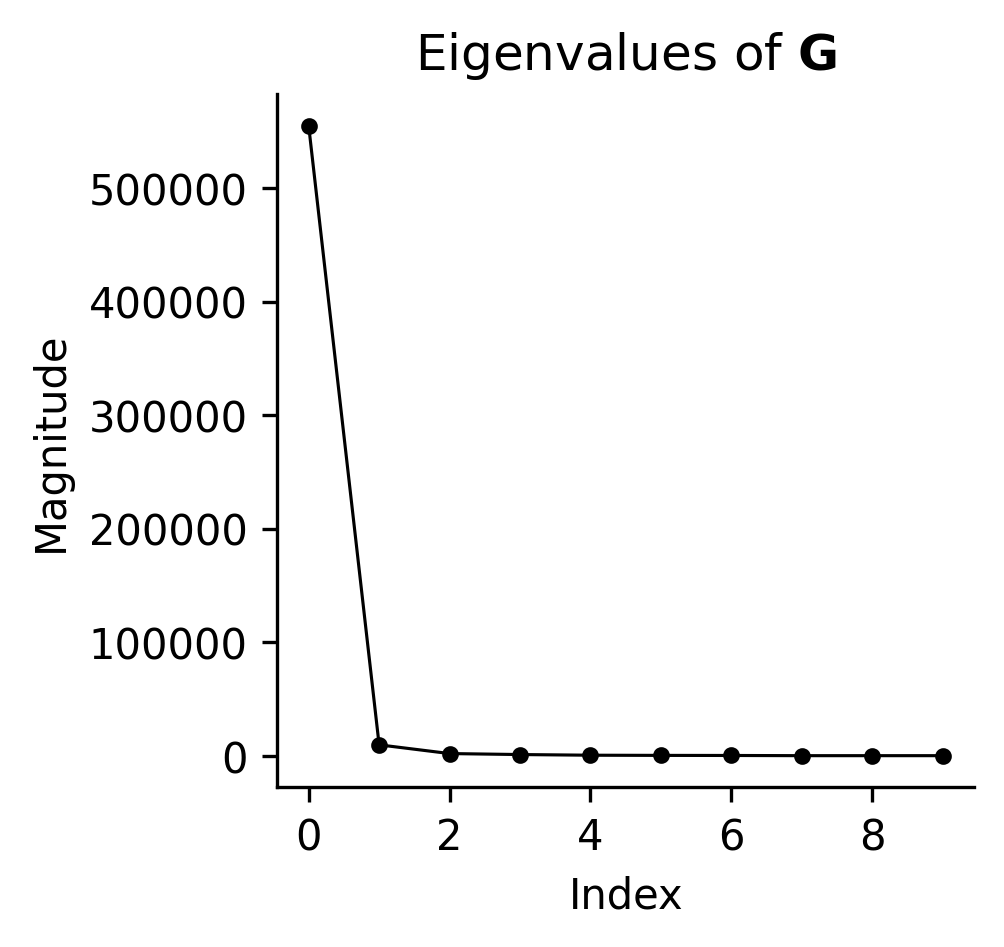

In [12]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
D, V = np.linalg.eig(G)
print(f"{D.shape=}{ V.shape=}")

n_val = 10
evals = np.real(D[:n_val])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

plt.plot(evals, lw=0.75, c='k', marker=".")
plt.title(r"Eigenvalues of $\mathbf{G}$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

print(f"{evals.max()=:.4f} {evals.min()=:.4f}")

# plt.gca().set_facecolor("None")
sns.despine()

evals.max()=554957.9969 evals.min()=-0.0000


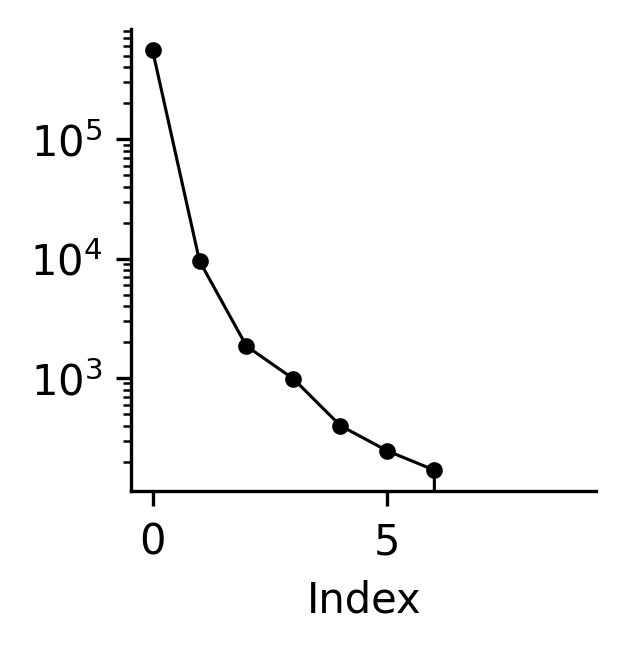

In [68]:
n_val = 10
evals = np.real(D[:n_val])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2
plt.rcParams['figure.facecolor'] = "None"

plt.plot(evals, lw=0.75, c='k', marker=".")
# plt.title(r"Eigenvalues of $\mathbf{G}$")
# plt.ylabel(r"Magnitude")
plt.yscale("log")
plt.xlabel(r"Index")

print(f"{evals.max()=:.4f} {evals.min()=:.4f}")

# plt.gca().set_facecolor("None")
sns.despine()

In [13]:
obs = pd.DataFrame({'gene' : high_exp_genes,
                    'ev1' : V[:,0],
                    'weight' : np.real(V[:,0])})

obs['rank'] = obs['weight'].rank(ascending=False)
obs = obs.sort_values(by='rank', ascending=True)

obs.head(10)

gene                 ev1    weight  rank
2480    GAPDH  0.451382+0.000000j  0.451382   1.0
6966   TMSB4X  0.343181+0.000000j  0.343181   2.0
573       B2M  0.250875+0.000000j  0.250875   3.0
2927  HLA-DRA  0.238720+0.000000j  0.238720   4.0
2433      FTL  0.212943+0.000000j  0.212943   5.0
7233     TUBB  0.183250+0.000000j  0.183250   6.0
4707    PCBP1  0.156209+0.000000j  0.156209   7.0
3019    HSPA8  0.155838+0.000000j  0.155838   8.0
91      ACTG1  0.151797+0.000000j  0.151797   9.0
4813     PFN1  0.149292+0.000000j  0.149292  10.0

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


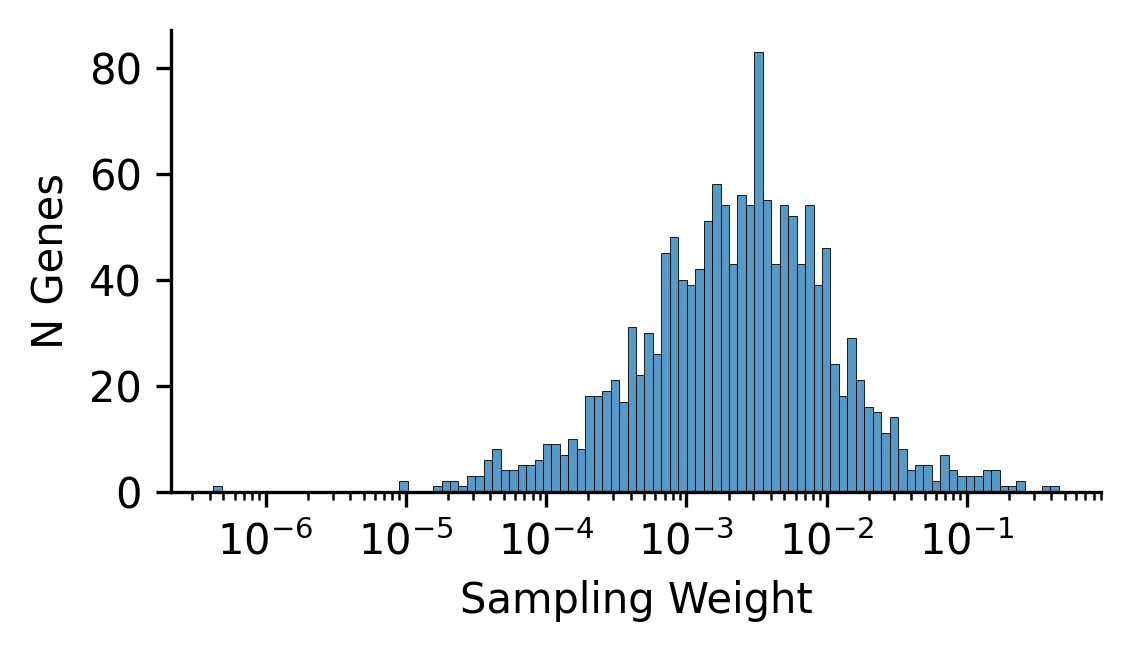

In [14]:
pdf = obs.copy()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

sns.histplot(data=pdf, 
             x='weight', 
             bins=100,
             log_scale=True,)

plt.ylabel('N Genes')
plt.xlabel('Sampling Weight')
sns.despine()

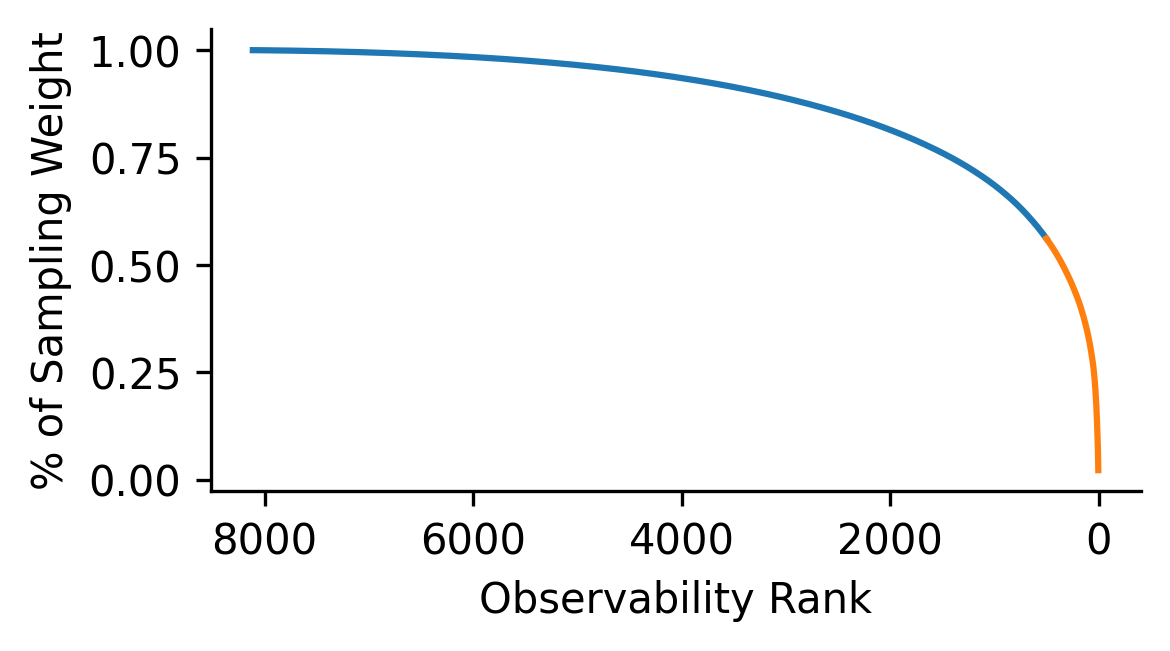

In [15]:
n = 500
pdf = obs.copy()
pdf['cat'] = np.where(pdf['rank'] < n, 1, 0)
pdf['weight_scaled'] = pdf['weight'] - pdf['weight'].min()
pdf['cumsum'] = pdf['weight_scaled'].cumsum() / pdf['weight_scaled'].sum()
pdf['obs_rank'] = pdf['rank'] + 1

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2



sns.lineplot(data=pdf, 
             x='obs_rank',
             y='cumsum',
             hue='cat')

sns.despine()
plt.ylabel("% of Sampling Weight")
plt.xlabel("Observability Rank")
plt.gca().legend().remove()
# plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# plt.yscale('log')
# plt.xscale('log')

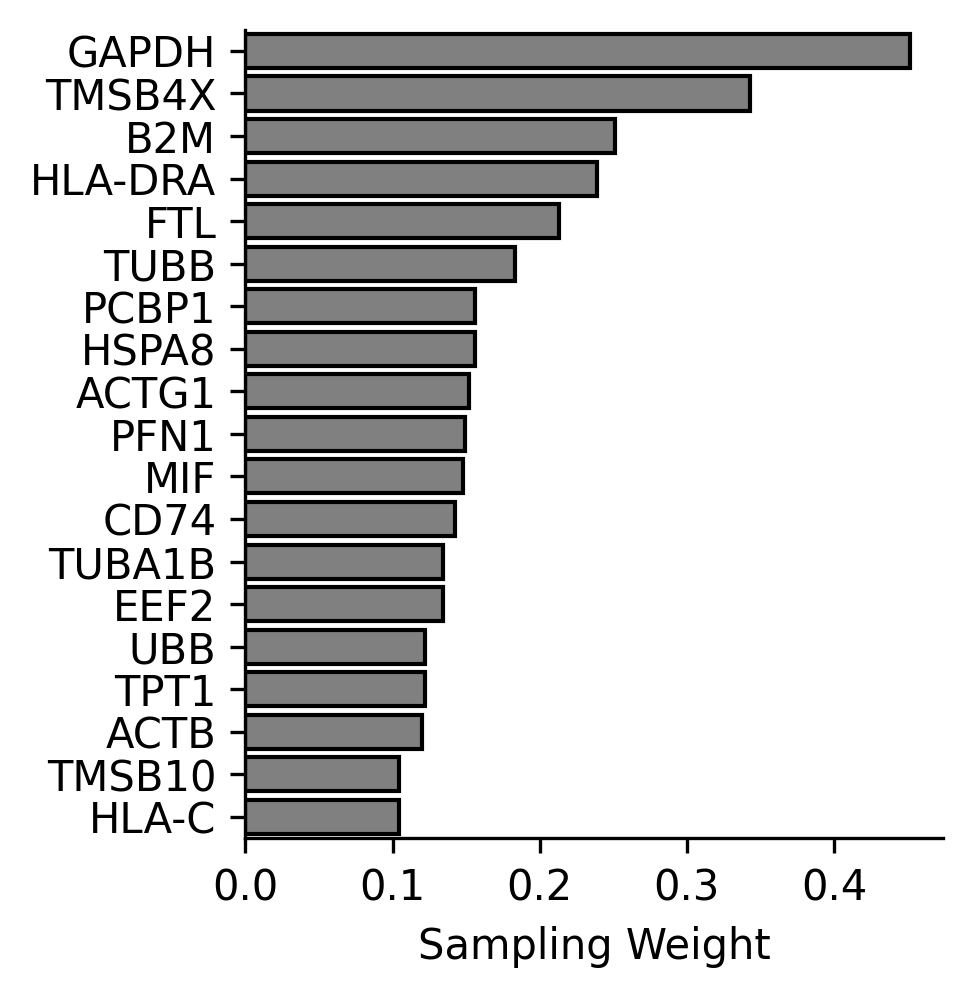

In [16]:
top = 20

pdf = obs.copy()
pdf = pdf[pdf['rank'] < top]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3.5

sns.barplot(data=pdf,
            y='gene',
            x='weight',
            color='grey',
            ec='k')

plt.ylabel("")
plt.xlabel("Sampling Weight")
sns.despine()

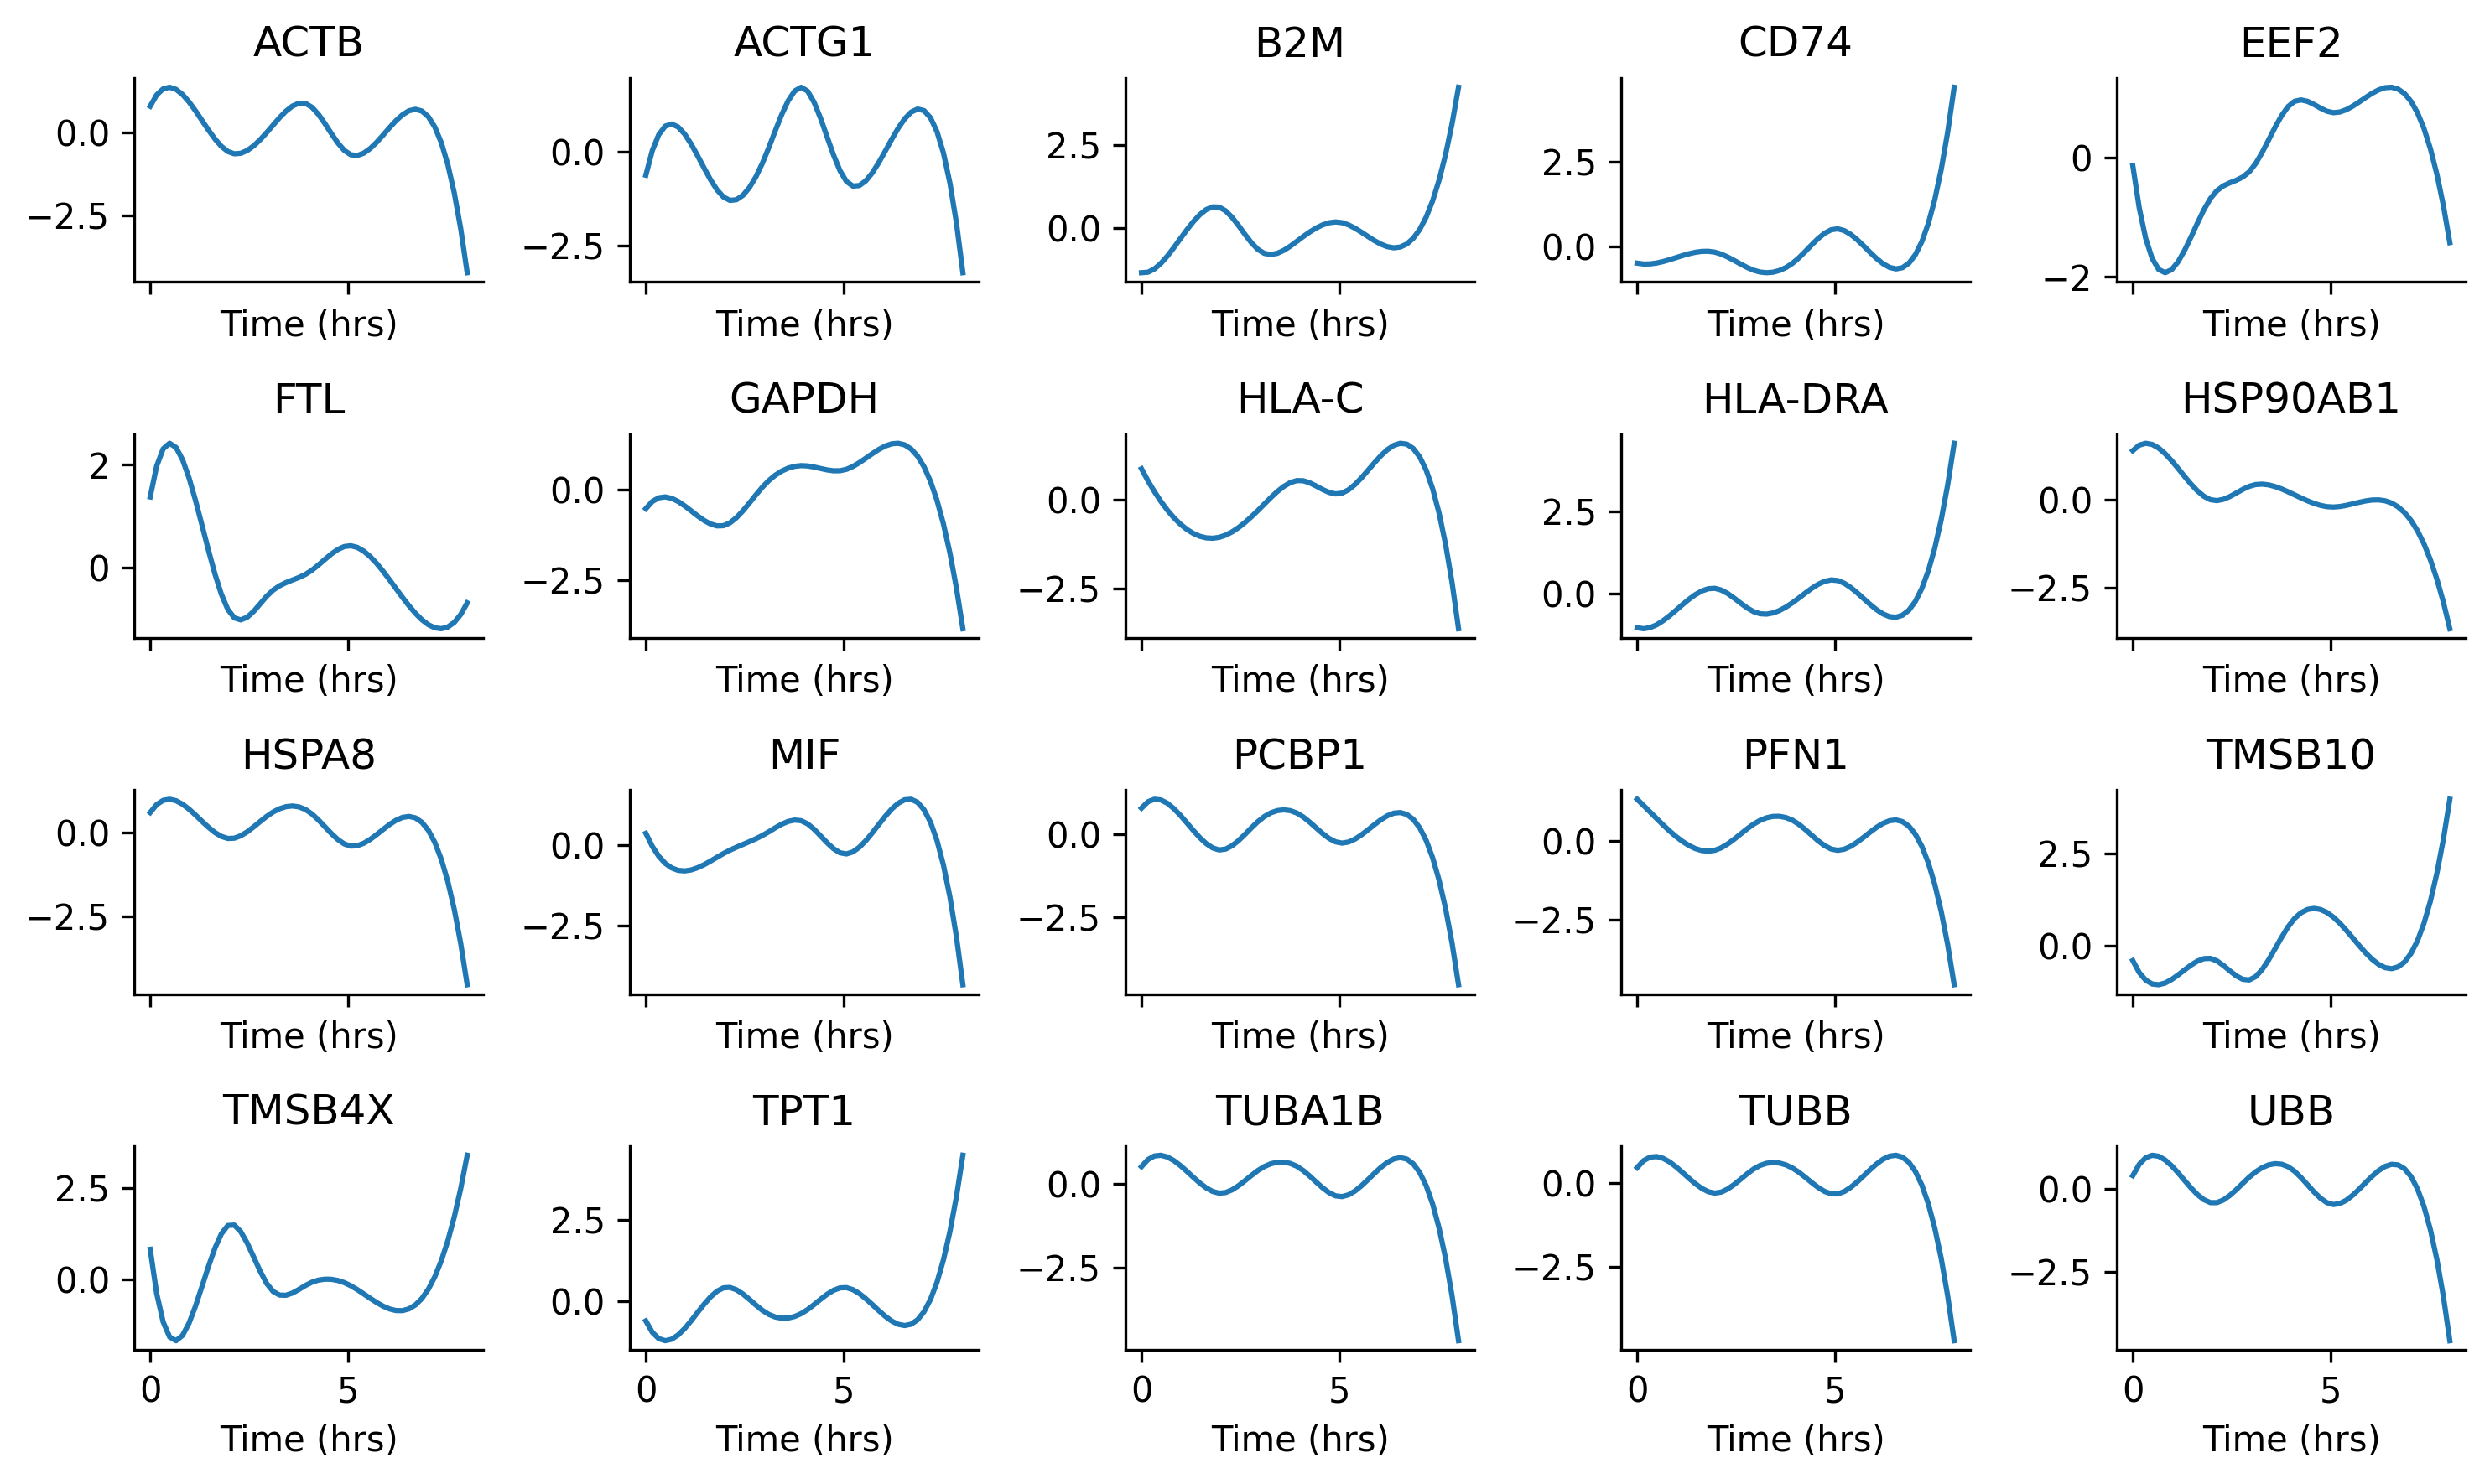

In [17]:
top = 20
top_genes = obs[obs['rank'] < top+1]['gene'].to_list()


# get the normalized expression data
pdf = d.copy()
pdf = pdf.reset_index(drop=False)
pdf = nb.meltDf(pdf)
pdf = pdf[pdf['control'] != 'control']
pdf = pdf[pdf['geneName'].isin(top_genes)]


pdf = pd.pivot_table(pdf, 
                 index='geneName', 
                 columns='hours',
                 values='value',
                 aggfunc='mean')


smooth = smooth_rows(pdf, n_points=50, power=3)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 6
fig, axs = plt.subplots(4, 5, sharex=True)
axs = axs.ravel()

for i, (idx, row) in enumerate(smooth.iterrows()):
    axs[i].plot(smooth.columns.to_list(),
                row.to_list(),)
    axs[i].set_title(idx)
    axs[i].set_ylabel("")
    # axs[i].set_yticks([])
    axs[i].set_xlabel("Time (hrs)")
    

sns.despine()
plt.tight_layout()


In [83]:
top = 20
top_genes = obs[obs['rank'] < top+1]['gene'].to_list() 

gene_table = pd.read_csv(gene_path)
gene_table = gene_table[gene_table['Feature'] == 'gene']
gene_table = gene_table[gene_table['gene_name'].isin(top_genes)]
print(f"{gene_table.shape=}")


info_table = gget.info(gene_table['gene_id'].to_list())
print(f"{info_table.shape=}")
info_table.columns

/home/cstansbu/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


gene_table.shape=(20, 26)
info_table.shape=(20, 32)


Index(['ensembl_id', 'uniprot_id', 'ncbi_gene_id', 'species', 'assembly_name',
       'primary_gene_name', 'ensembl_gene_name', 'synonyms', 'parent_gene',
       'protein_names', 'ensembl_description', 'uniprot_description',
       'ncbi_description', 'object_type', 'biotype', 'canonical_transcript',
       'seq_region_name', 'strand', 'start', 'end', 'all_transcripts',
       'transcript_biotypes', 'transcript_names', 'transcript_strands',
       'transcript_starts', 'transcript_ends', 'all_exons', 'exon_starts',
       'exon_ends', 'all_translations', 'translation_starts',
       'translation_ends'],
      dtype='object')

In [89]:
for idx, row in info_table.iterrows():
    print(f"==== {row['primary_gene_name']} ====")
    print(row['ncbi_description'])
    print()

==== TMSB10 ====
Predicted to enable actin monomer binding activity. Predicted to be involved in regulation of cell migration and sequestering of actin monomers. Predicted to be located in cytoskeleton. Predicted to be active in cytoplasm. [provided by Alliance of Genome Resources, Apr 2022]

==== PCBP1 ====
This intronless gene is thought to have been generated by retrotransposition of a fully processed PCBP-2 mRNA. This gene and PCBP-2 have paralogues (PCBP3 and PCBP4) which are thought to have arisen as a result of duplication events of entire genes. The protein encoded by this gene appears to be multifunctional. It along with PCBP-2 and hnRNPK corresponds to the major cellular poly(rC)-binding protein. It contains three K-homologous (KH) domains which may be involved in RNA binding. This encoded protein together with PCBP-2 also functions as translational coactivators of poliovirus RNA via a sequence-specific interaction with stem-loop IV of the IRES and promote poliovirus RNA repl

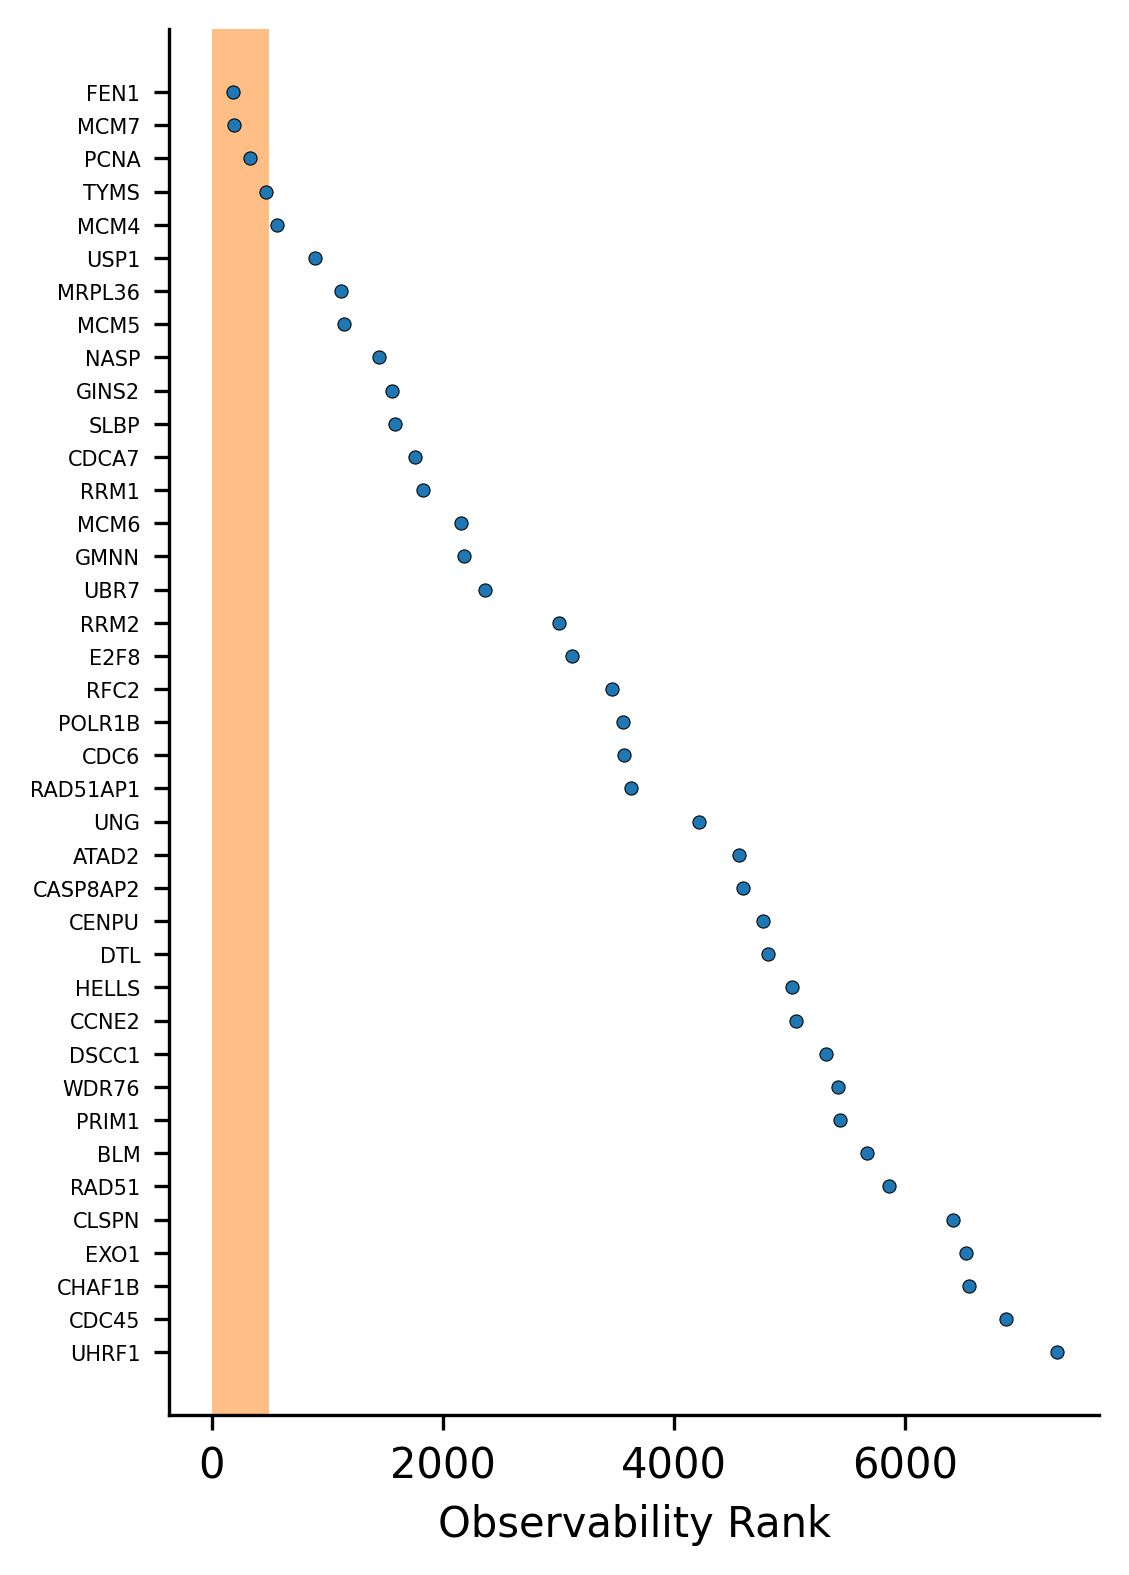

In [18]:
cell_cycle = nb.s_genes 
# cell_cycle = nb.g2_genes 

pdf = obs.copy()
pdf = pdf[pdf['gene'].isin(cell_cycle)]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 6

sns.scatterplot(data=pdf, 
                y='gene',
                x='rank',
                s=10,
                ec='k',
                zorder=3
               )

plt.axvspan(0, 500, 
            zorder=1, 
            color='C1',
            ec='none',
            alpha=0.5)

plt.ylabel("")
plt.xlabel("Observability Rank")
plt.gca().tick_params(axis='y', labelsize=5)
sns.despine()

In [19]:
n_gene = 500
# genes = obs['gene'].head(n_gene).to_list()
genes = obs['gene'].head(n_gene).to_list()

# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

edf = gget.enrichr(genes, database=db)
pd.set_option('display.max_colwidth', 100)
print(edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(20))



Thu Nov  2 08:47:28 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


                                                                                            path_name  \
0                                                    cytokine-mediated signaling pathway (GO:0019221)   
1                                                           regulation of mRNA stability (GO:0043488)   
2   RNA splicing, via transesterification reactions with bulged adenosine as nucleophile (GO:0000377)   
3                                                         mRNA splicing, via spliceosome (GO:0000398)   
4                                                                        mRNA processing (GO:0006397)   
5                                           negative regulation of programmed cell death (GO:0043069)   
6                                                   regulation of mRNA catabolic process (GO:0061013)   
7                                                        regulation of apoptotic process (GO:0042981)   
8                                               negativ

rank  \
11   6.0   
45  11.0   
49  73.0   
68  77.0   
75  77.0   

                                                                  path_name  \
11           regulation of mitotic cell cycle phase transition (GO:1901990)   
45                                    regulation of cell cycle (GO:0051726)   
49                            regulation of mitotic cell cycle (GO:0007346)   
68  negative regulation of mitotic cell cycle phase transition (GO:1901991)   
75                   regulation of cell cycle phase transition (GO:1901987)   

           p_val   z_score  combined_score  \
11  3.627551e-10  5.650276      122.821714   
45  4.789743e-07  3.564261       51.865768   
49  5.544125e-07  4.514004       65.025841   
68  3.089524e-06  5.969262       75.734976   
75  4.349290e-06  5.752617       71.018922   

                                                                                      overlapping_genes  \
11  [HSP90AA1, UBE2C, TUBB, SSNA1, TUBB4B, ZFP36L2, PSMA7, PSMB8, ZFP36L1, CDC20, PSMB6, CCNB1, PSMB...   
45  [PPP1R15A, GADD45GIP1, CDKN1A, JUND, HSP90AB1, GADD45B, CSNK2A3, HNRNPU, RAD23A, MIF, RNF167, CC...   
49  [BTG2, BTG1, UBE2C, HNRNPU, MKI67, PSMA7, PSMB8, CDC20, PSMB6, CCNB1, PSMB4, PSMC5, PSME1, CKS2,...   
68           [PSMB6, CDKN1A, PSMB4, PSMC5, CDK4, PSME1, CDK2AP2, PSME2, PSMA7, ZFP36L2, PSMB8, ZFP36L1]   
75                 [CDC20, PSMB6, CDKN1A, CCNB1, PSMB4, PSMC5, UBE2C, PSME1, PSME2, BUB3, PSMA7, PSMB8]   

       adj_p_val                    database  n_gene      logp  \
11  8.551951e-08  GO_Biological_Process_2021      23  7.067935   
45  2.890041e-05  GO_Biological_Process_2021      24  4.539096   
49  3.136866e-05  GO_Biological_Process_2021      18  4.503504   
68  1.266705e-04  GO_Biological_Process_2021      12  3.897325   
75  1.609337e-04  GO_Biological_Process_2021      12  3.793353   

                                                           name  \
11           Regulation of mitotic cell cycle phase transition    
45                                    Regulation of cell cycle    
49                            Regulation of mitotic cell cycle    
68  Negative regulation of mitotic cell cycle phase transition    
75                   Regulation of cell cycle phase transition    

                                                       name_sig  cell_cycle  
11           Regulation of mitotic cell cycle phase transition*           1  
45                                    Regulation of cell cycle*           1  
49                            Regulation of mitotic cell cycle*           1  
68  Negative regulation of mitotic cell cycle phase transition*           1  
75                   Regulation of cell cycle phase transition*           1

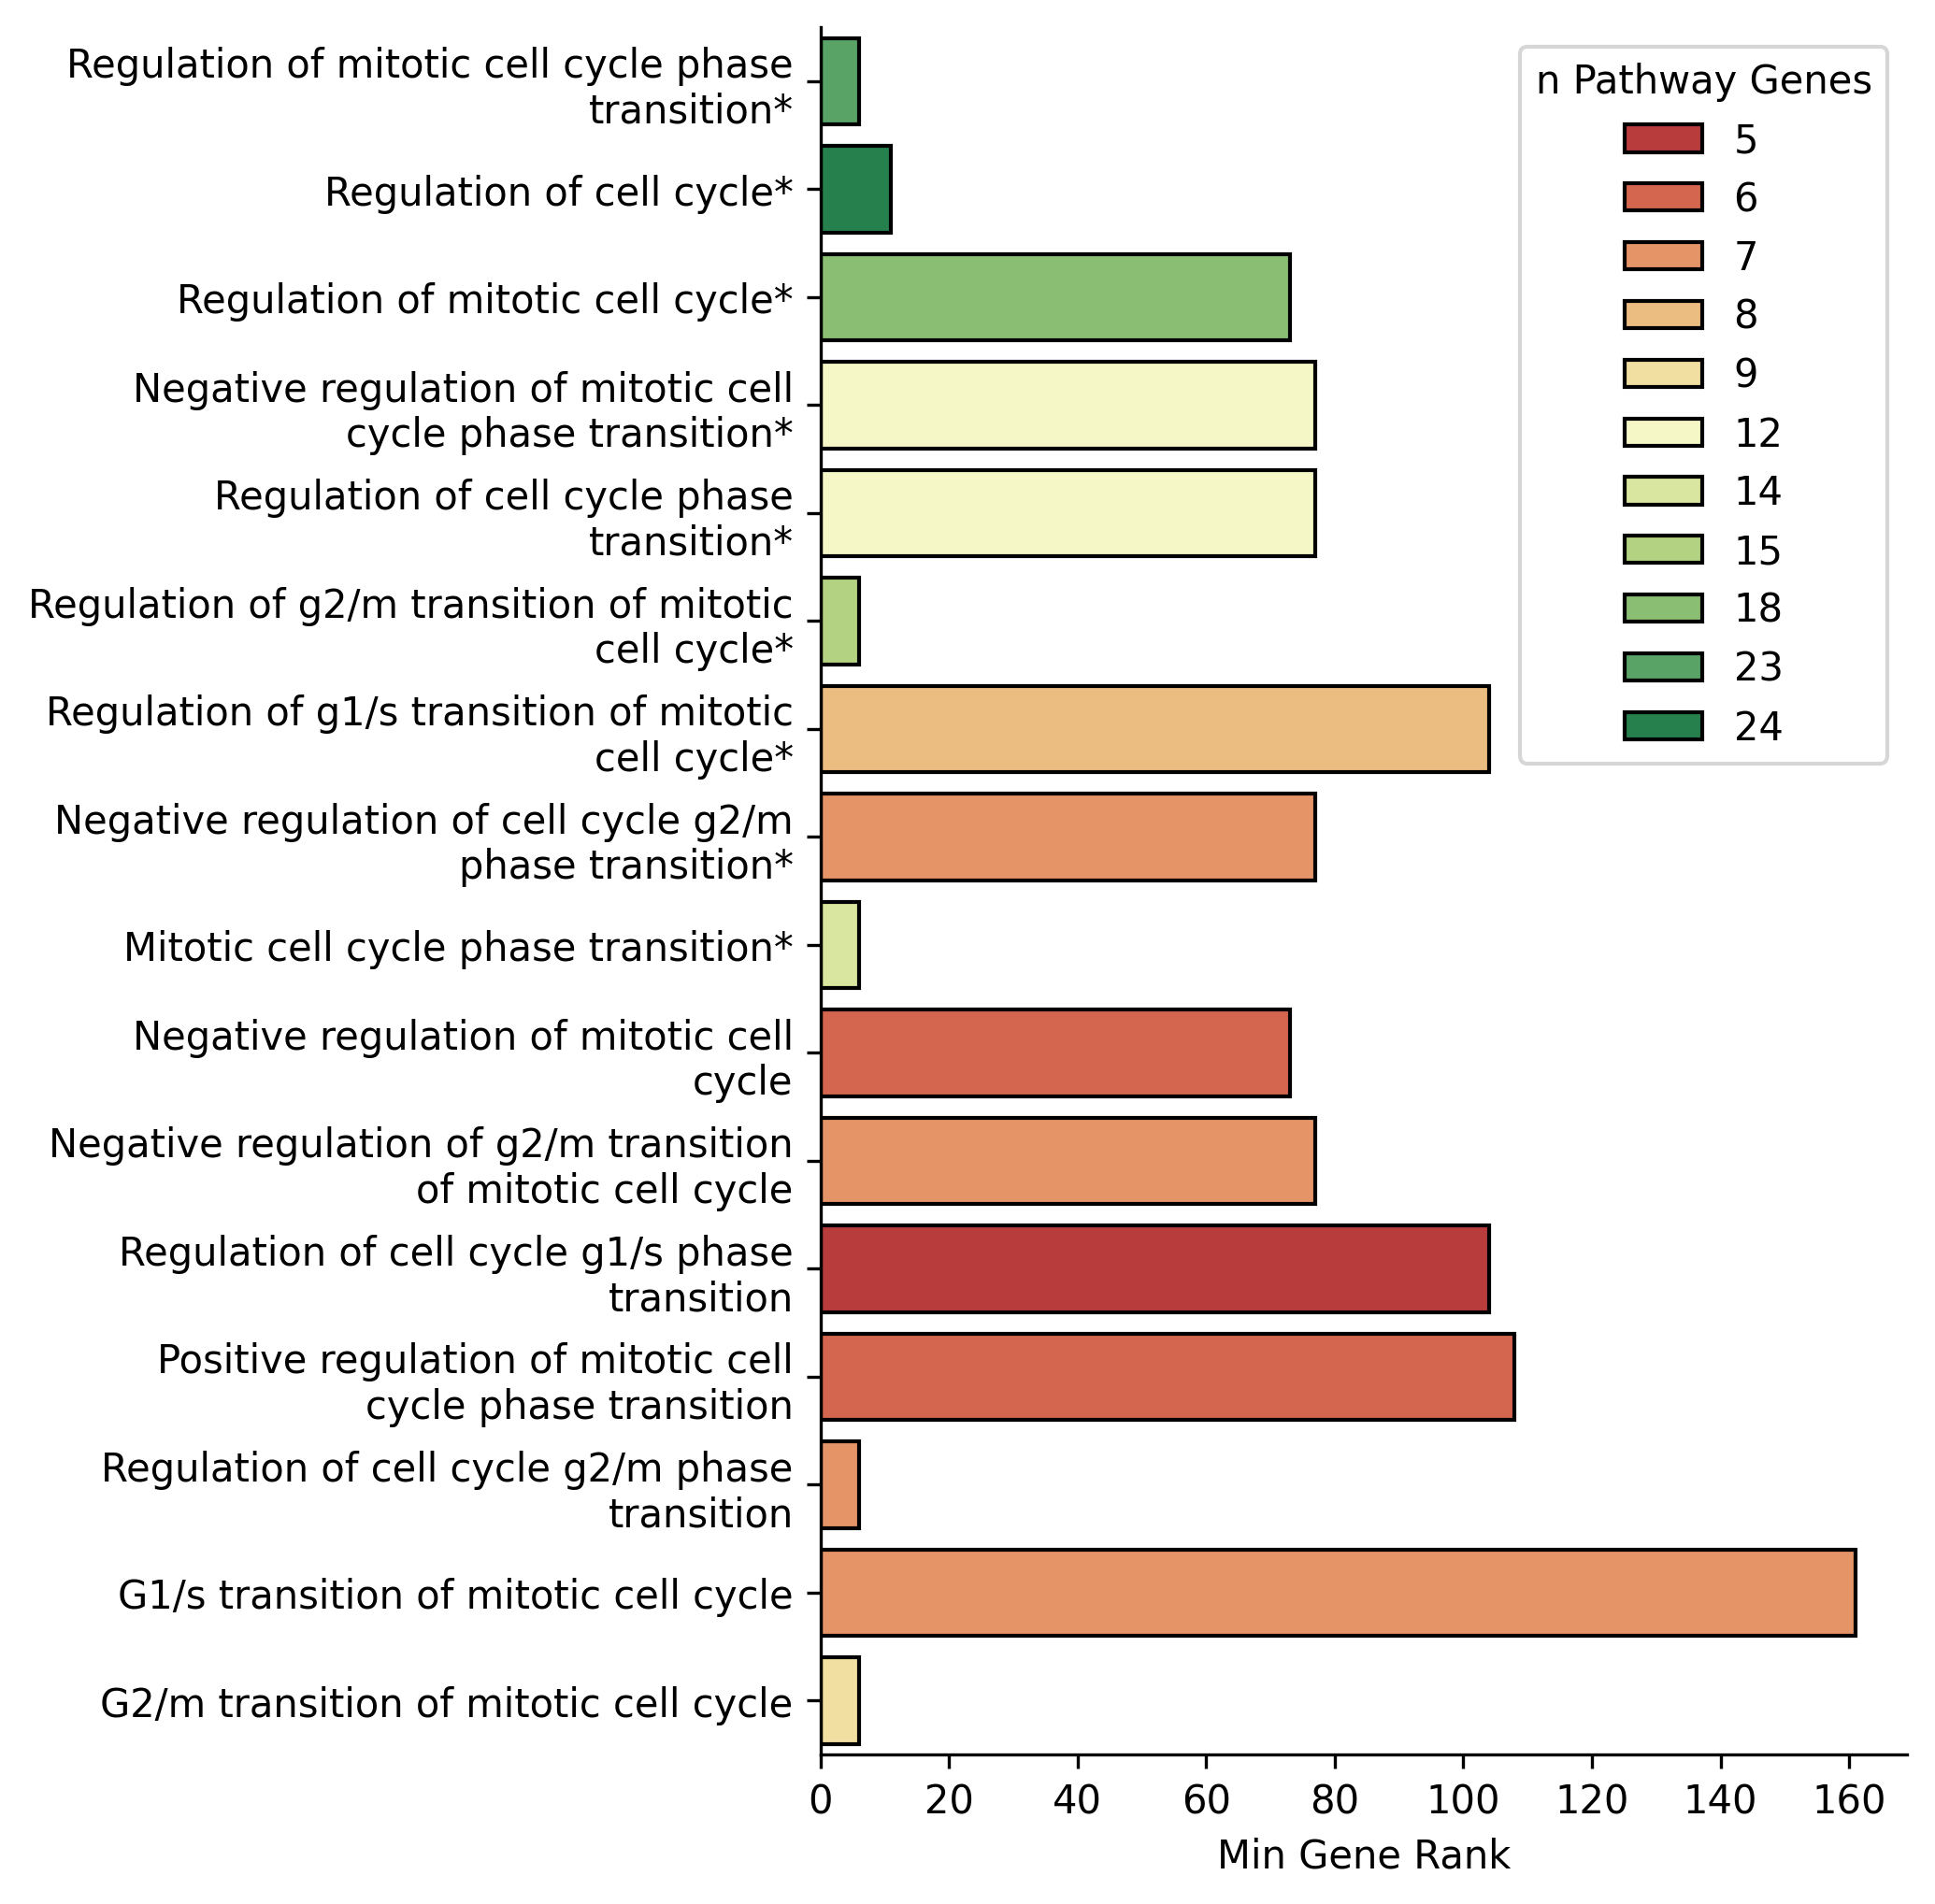

In [20]:
thresh = 0.01
pdf = edf.copy()
pdf = pdf[pdf['adj_p_val'] <= alpha]

pdf['n_gene'] = pdf['overlapping_genes'].apply(lambda x: len(x))
pdf['logp'] = -1 * np.log10(pdf['adj_p_val'])
pdf['name'] = pdf['path_name'].apply(lambda x: x.split("(")[0].capitalize())
pdf['name_sig'] = pdf[['name', 'adj_p_val']].apply(lambda x: x[0].strip() + "*" if x[1] < thresh else x[0], axis=1)

# get the cell cycle processes
pdf['cell_cycle'] = pdf['name'].apply(lambda x: 1 if 'cell cycle' in x else 0)
pdf = pdf[pdf['cell_cycle'] == 1]

pdf['rank'] = pdf['overlapping_genes'].apply(lambda x: obs[obs['gene'].isin(x)]['rank'].min())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 8

sns.barplot(data=pdf, 
            y='name_sig',
            x='rank',
            hue='n_gene',
            dodge=False,
            ec='k',
            palette='RdYlGn')

plt.ylabel("")
plt.xlabel("Min Gene Rank")
wrap_ylabels(plt.gca(), width=40)
sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                title='n Pathway Genes')
pdf.head()

In [21]:
# break

# State estimation

In [22]:
## state estimation
rep = 0
t = 7 # not including the initial condition
x0 = dmd_data[:, 0, rep]
A = dmd_res['A']

Kt = []

for i in np.arange(0, t):
    print(f"Computing A^{i}...")
    At = np.linalg.matrix_power(A, i)
    Kt.append(At)

print('done')

Computing A^0...
Computing A^1...
Computing A^2...
Computing A^3...
Computing A^4...
Computing A^5...
Computing A^6...
done


In [51]:
""" Build the observed data matrix: need to only index the sensors, or all?"""

def estimate_z0(n_sensors, nT, Kt, data, V):
    """A function to estimate the initial condition given:
        : n_sensors (int) the number of top sensors to select, given the principal eigenvector of the Gram matrix
        : nT (int): number of timepoints for which to construct the estimation. Bounded the len(Kt).
        : Kt (list of gene x gene array): The precomputed exponentiation of the learned dynamics from DMD 
        : data (gene x time): the original data for a single replicate
        : V : the eigenvectors of the Gram matrix (columns are eigenvectors)
    """
    # get the gene sampling wieghts and select sensors
    q1 = np.real(V[:,0])
    ind = np.argpartition(q1, -n_sensors)[-n_sensors:] # leading eigenvector
    w = np.zeros(q1.shape)
    w[ind] = q1[ind]

    # compute the measurements and the esitmated dynamics, given the 
    # selected sensors
    # outputs
    yt = []
    O = []
    for i in np.arange(0, nT):
        # print(i)
        yt.append( np.dot(w, data[:, i]))
    
        if i == 0:
            O.append(w)
        else:
            wKt = np.dot(w, Kt[i])
            O.append(wKt)

    yt = np.asarray(yt)
    O = np.asarray(O)
    # print(f"{yt.shape=} {O.shape=}")
    z0 = np.dot(np.linalg.pinv(O), yt)
    return z0
    
n_sensors = 10
nT = 7
data = dmd_data[:, :, 1]
z0 = estimate_z0(n_sensors, nT, Kt, data, V)

np.linalg.norm(z0 - x0)

7.477028990613803

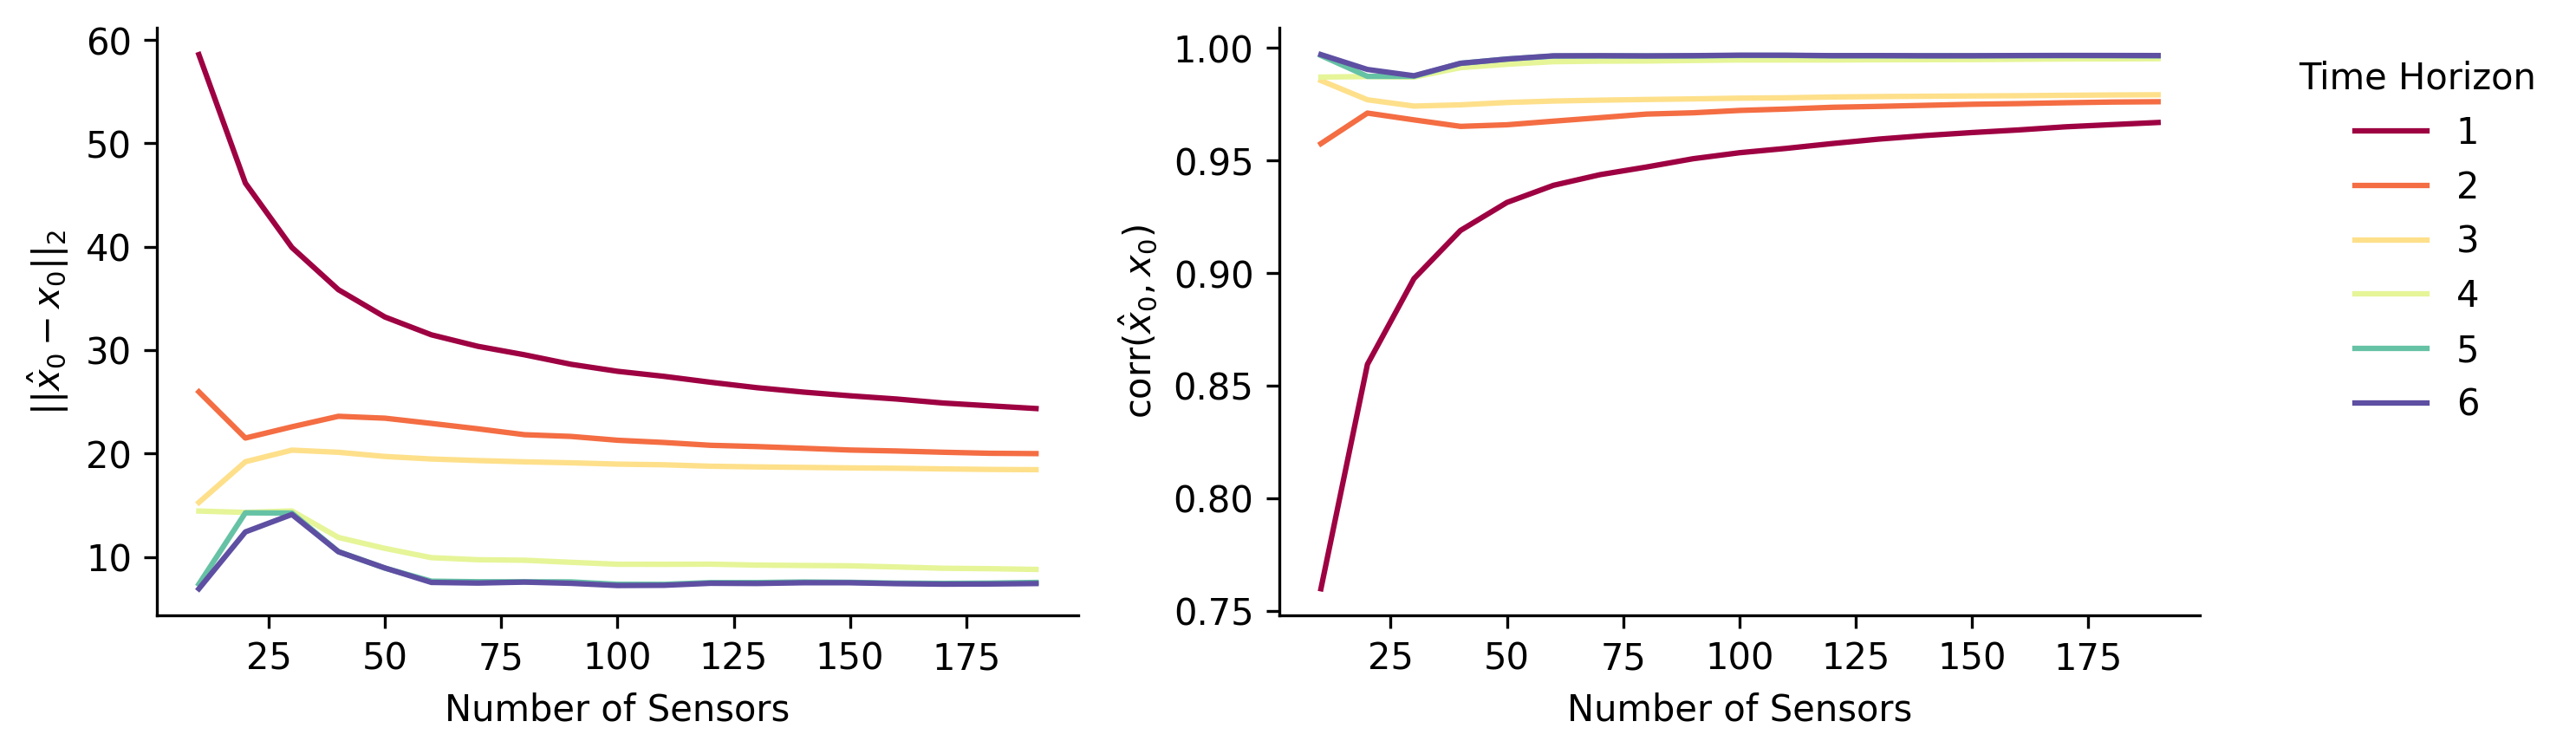

In [60]:
nT = 7
data = dmd_data[:, :, 0]

res = []
diffs = []

for n_sensors in np.arange(10, 200, step=10):
    for nT in np.arange(1, 7):
        z0 = estimate_z0(n_sensors, nT, Kt, data, V)
        score, pval = scipy.stats.pearsonr(z0, x0)
        l2 = np.linalg.norm((z0-x0))
    
        diff = z0 - x0
        diffs.append(diff)
        
        row = {
            'n_sensors' : n_sensors,
            'corr' : score,
            'pval' : pval,
            'norm' : l2,
            'nT' : nT,
        }
        res.append(row)
    
res = pd.DataFrame(res)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 3

cmap = 'Spectral'

fig, axs = plt.subplots(1, 2)

sns.lineplot(data=res, 
              x='n_sensors',
              hue='nT',
              ax=axs[0],
              palette=cmap,
              y='norm')

axs[0].set_ylabel(r"$||\hat{x}_0 - x_0||_2$")
axs[0].set_xlabel("Number of Sensors")
axs[0].legend().remove()

sns.lineplot(data=res, 
              x='n_sensors',
              hue='nT',
              ax=axs[1],
              palette=cmap,
              y='corr')

axs[1].set_ylabel(r"corr$(\hat{x}_0, x_0)$")
axs[1].set_xlabel("Number of Sensors")

sns.move_legend(axs[1],
                loc='upper right',
                frameon=False,
                title='Time Horizon',
                bbox_to_anchor=(1.4, 1))

sns.despine()
plt.tight_layout()

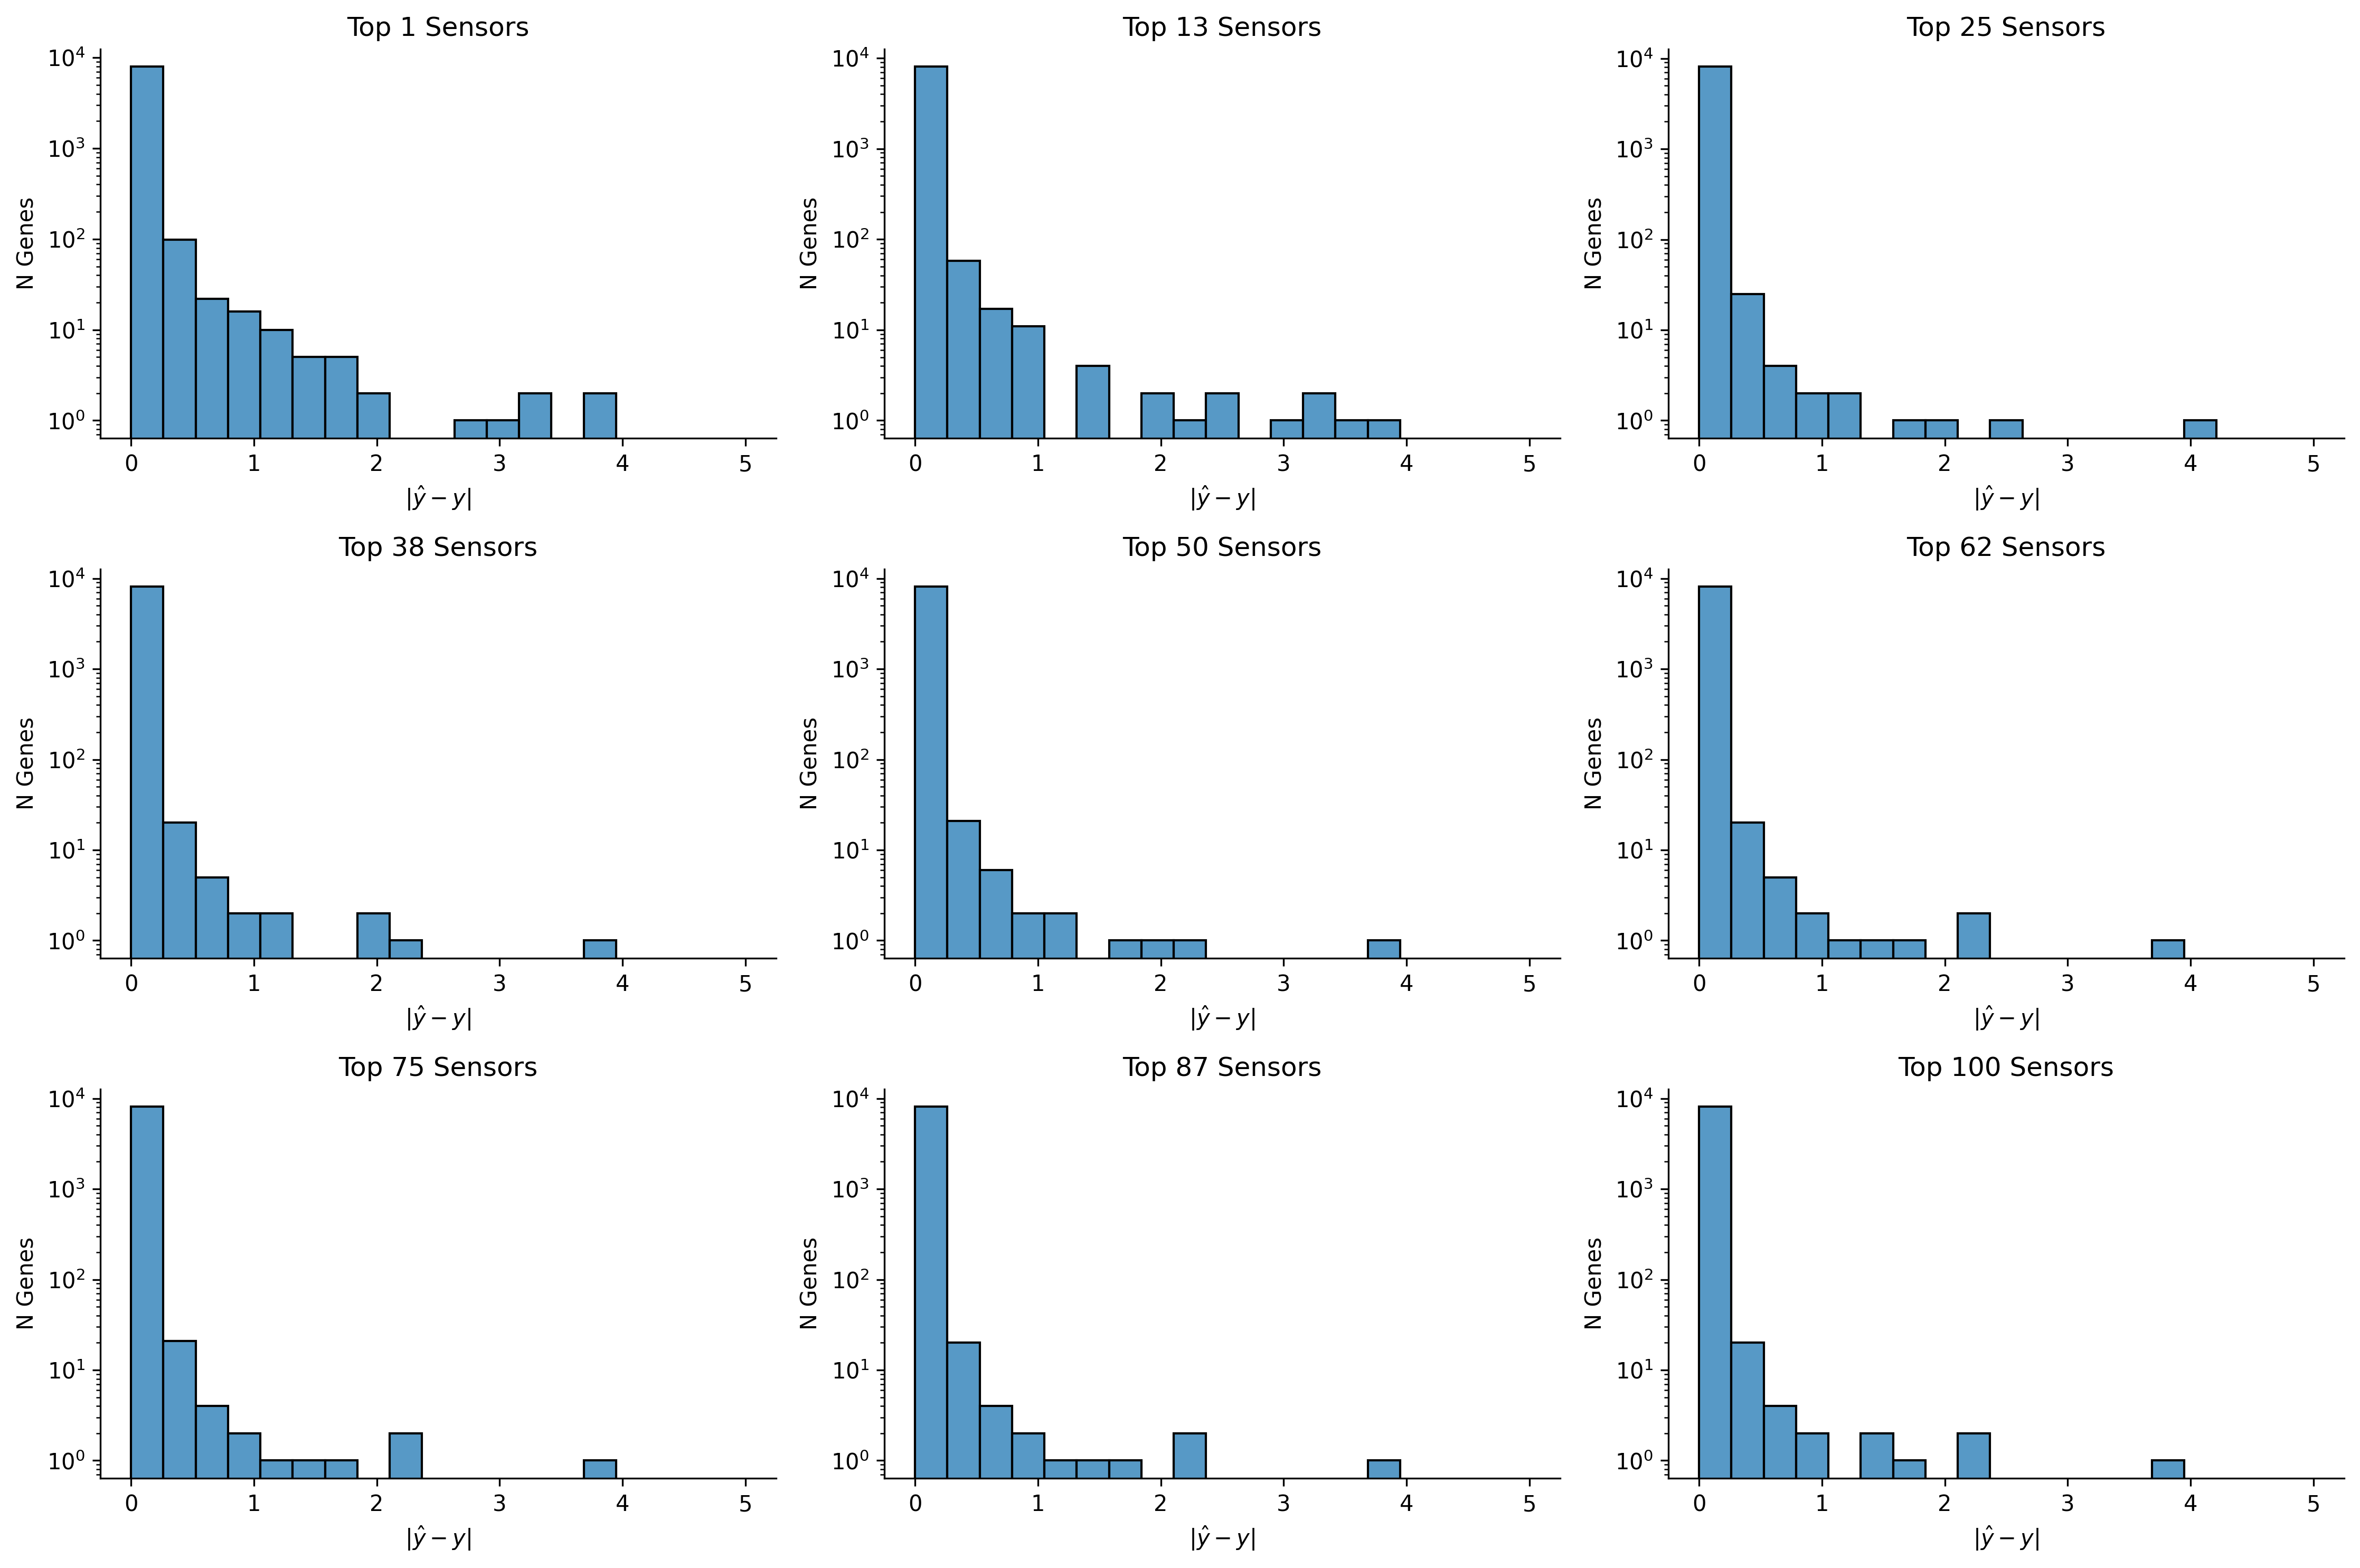

In [136]:
nT = 7
data = dmd_data[:, :, 0]
n = 9 # number of plots

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 10
fig, axs = plt.subplots(3, 3)
axs = axs.ravel()


for i, n_sensors in enumerate(np.linspace(1, 100, n).astype(int)):
    z0 = estimate_z0(n_sensors, nT, Kt, data, V)

    diff = np.abs(z0 - x0)

    sns.histplot(diff, 
                 bins=np.linspace(0, 5, 20),
                 ax=axs[i])
    
    axs[i].set_yscale('log')
    axs[i].set_ylabel('N Genes')
    axs[i].set_xlabel(r'$|\hat{y} - y$|')
    axs[i].set_title(f"Top {n_sensors} Sensors")


plt.tight_layout()
sns.despine()

In [25]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
def select_sensors(V, n_sensors=10):
    q1 = np.real(V[:,0])
    ind = np.argpartition(q1, -n_sensors)[-n_sensors:] # leading eigenvector
    w = np.zeros(q1.shape)
    w[ind] = q1[ind]
    return w
    

def reconstruct_x0(data,nT,A,C):
    '''
    The matrix C should be of shape (pxn) if the data are shape (nxm) for p measured genes, n total genes, and m samples
    If p << n, leave only entries of C that correspond to the p genes as nonzero.
    '''
    # generate outputs at nT timepoints, check rank of O_T, and estimate IC
    O_T = np.zeros((len(C)*nT,C.shape[1])) # O_T has dim p*nT x n
    for ii in range(O_T.shape[0]): # observability matrix
        O_T[ii] = C @ np.linalg.matrix_power(A,ii)    

    # use the learned dynamics and sampling to generate output over time
    y = np.zeros((len(C),nT)) 
    for ii in range(nT):
        y[:,ii] = C @ np.linalg.matrix_power(A,ii) @ data[:,0]

    # estimate of x0 
    x0_est = np.linalg.pinv(O_T) @ y.T

    return x0_est


n_sensors = 10
C = select_sensors(V, n_sensors=10)
C = np.expand_dims(C, axis=0)
nT = 3
data = dmd_data[:, :, 0]
x0 = dmd_data[:, 0, 0]
A = dmd_res['A']

z0 = reconstruct_x0(data, nT, A, C)

l2 = np.linalg.norm(z0 - x0)
score, pval = scipy.stats.pearsonr(np.squeeze(z0), x0)
print(f"{n_sensors=} {nT=} {l2=} {score=} {pval=}")

In [ ]:
# get the sensors
w = np.real(V[:,0])
ind = np.argpartition(w, -n_sensors)[-n_sensors:]
w_bin = np.zeros(w.shape)
w_bin[ind] = w[ind]

print(np.asarray(gene_names)[ind])

yt_true = dmd_data[:, t-1, rep] # t-1 for index offset
A = dmd_res['A']

print(f"{A.shape=} {x0.shape=} {w.shape=} {yt_true.shape=}")

At = np.linalg.matrix_power(A, t)
print(f"{At.shape=}")

In [ ]:
# get the sensors
n_sensors = 100
w = np.real(V[:,0:n_sensors])
C = np.zeros(w.shape)

row_ind = np.argpartition(w[:, 0], -n_sensors)[-n_sensors:] # leading eigenvector
col_ind = np.arange(0, n_sensors)

C[row_ind, col_ind] = 1
print(f"{C.shape=} {C.sum()=}")

yt_pred = np.dot(C.T, np.dot(At, x0))
print(f"{yt_pred.shape=} {yt_true.shape=} {yt_true[row_ind].shape=}")

# print()
# print(yt_true[ind])
# print()
# print(yt_pred)
# print()

np.corrcoef(yt_true[row_ind], yt_pred)


In [ ]:
np.corrcoef(yt_true[ind], test)

In [ ]:
test